# Introduction to deep learning



### Overview of the Moon dataset
The Moon dataset is an artificial dataset with two intertwined moon shapes belonging to two different classes.

The dataset is composed of 10000 data points with the following features:
- x position
- y position

So, our data matrix is of size (10000, 2); that is (`nb_data_points`, `nb_features`).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
from sklearn import datasets

# Here, we add some noise so that some points are a bit outside the moon shapes
X, y = datasets.make_moons(n_samples=10000, noise=0.05)

print("The data shape is {}\n".format(X.shape))
print("The first 5 data points are \n{}\n".format(X[:5]))
print("The first 5 labels are {}\n".format(y[:5]))
print("The last 5 data points are \n{}\n".format(X[-5:]))
print("The last 5 labels are {}".format(y[-5:]))

The data shape is (10000, 2)

The first 5 data points are 
[[-1.1175678   0.1459723 ]
 [ 1.72291634 -0.06819997]
 [ 1.05713615  0.09645611]
 [ 0.53287915  0.78672809]
 [-0.92663791  0.46286374]]

The first 5 labels are [0 1 0 0 0]

The last 5 data points are 
[[ 1.2464011  -0.51811818]
 [ 1.36347527 -0.52451783]
 [ 0.56547564 -0.52707653]
 [ 0.78557662  0.58786383]
 [ 1.95309344  0.10298788]]

The last 5 labels are [1 1 1 0 1]


Now, let us visualise what this dataset looks like.

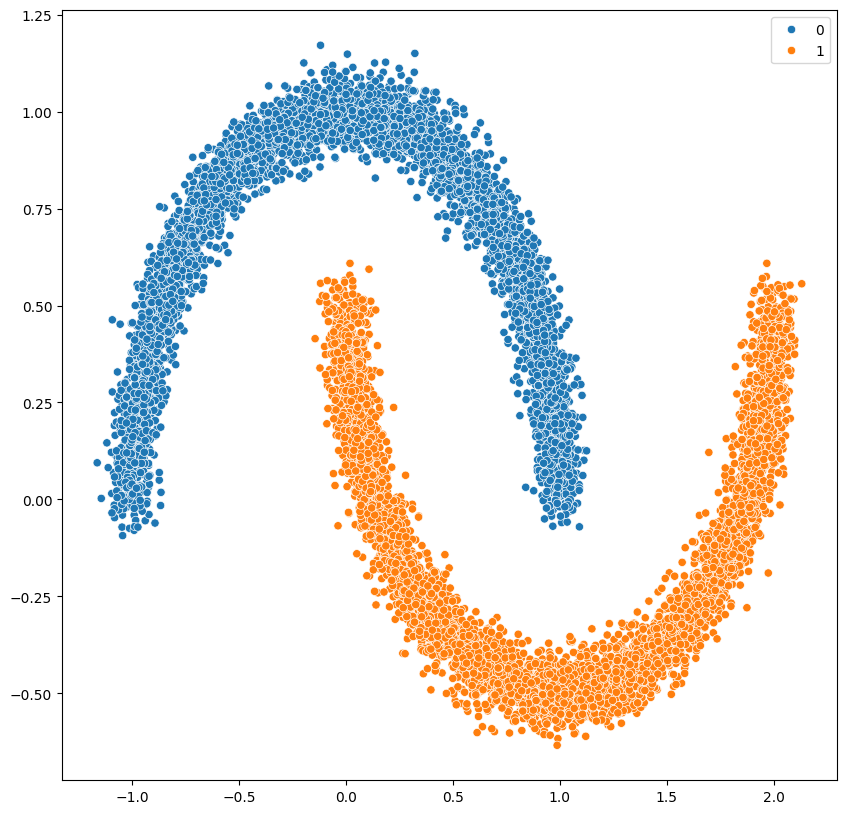

In [2]:
import seaborn as sns
import numpy as np
ax = sns.scatterplot(x=X[:,0], y=X[:,1], hue=y)

### Question 1 - Comparing logistic regression and deep learning
Now that we have our dataset, we will create a function to plot the decision boundary of our models and use it to compare the behaviour of a logistic regression and a deep learning model. Note that logistic regression is another name for our familiar delta rule when the sigmoid activation function is used.

#### Plotting decision boundaries
Nothing to do here, but you can explore this function to see what it does if you are curious about it.

Note that this part of the class is inspired by [scikit learn example on multinomial logistic regression](https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_multinomial.html#sphx-glr-auto-examples-linear-model-plot-logistic-multinomial-py).

In [3]:
# This function will plot the decision boundaries of any model given our 2D dataset. We will use this function many times in this class.
def plot_decision_boundaries(X, y, clf, step=None):
     # create a mesh to plot in
    h = 0.02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)
    plt.axis("tight")
    
    # If we are plotting the decision boundaries sequentially, we mention the corresponding epoch
    if step is not None:
        plt.title("Decision boundaries at epoch {}".format(step))

    # Plot also the training points
    colors = ["blue", "orange", "green"]
    for i, color in zip(range(3), colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, edgecolor="black", s=20)
    plt.show()

#### The decision boundary of a logistic regression model
Let us train a logistic regression model and plot its decision boundaries after training.

The decision boundary of the multinomial logistic regression


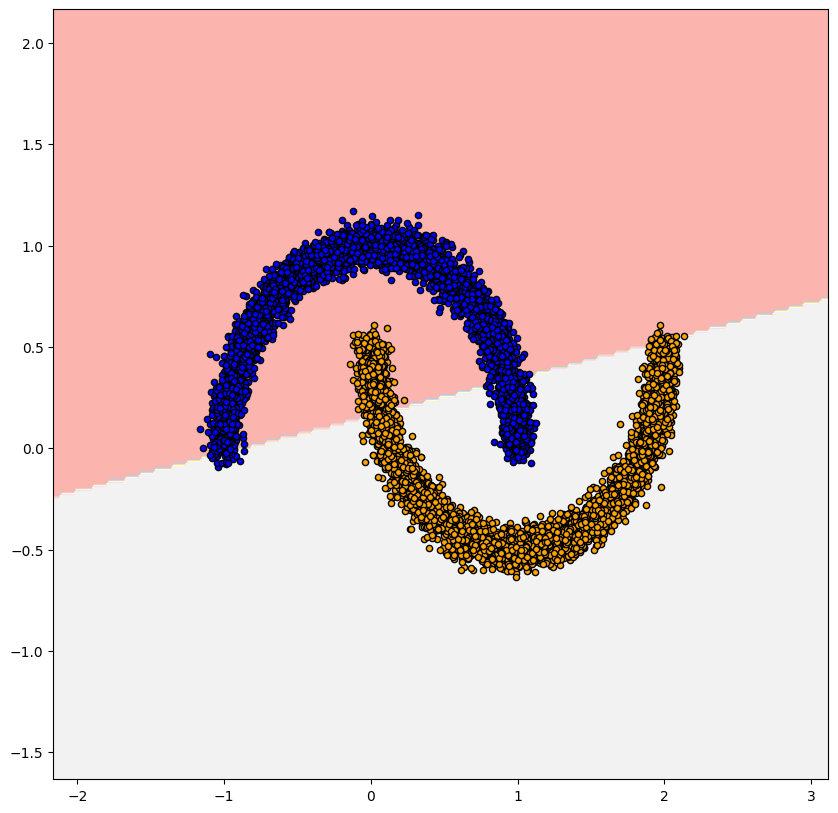

In [4]:
from sklearn.linear_model import LogisticRegression
# delta rule is used in the next line of code to fit the model to the data
clf = LogisticRegression(max_iter=100, random_state=0).fit(X, y)
print("The decision boundary of the multinomial logistic regression")
plot_decision_boundaries(X, y, clf)

- **(1-1):** Is the model accurately classifying every data point? Justify your answer.

- Explanation

Logistic regression is a linear classifier. This means its decision boundary is always a straight line (or, in multiple dimensions, a linear hyperplane).

But the moons dataset is non-linearly separable:

The two classes are shaped like two interlocking semicircles.

No straight line can perfectly separate them.

When you plot the logistic regression decision boundary, you should see:

A single straight line trying to split the two moons.

Many points from each class that lie on the wrong side of the line.


#### The decision boundary of a deep neural network
Now, let us create a simple neural network with no hidden layers and train it for a few epochs.

At the end of each epoch, we will plot the decision boundaries using the `BoundariesCallback` defined below.

In [5]:
import tensorflow as tf 

class BoundariesCallback(tf.keras.callbacks.Callback):
    def __init__(self, X, y, clf, plot_freq=2):
        self._X = X
        self._y = y
        self._clf = clf
        self._plot_freq = plot_freq

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self._plot_freq == 0:
            plot_decision_boundaries(self._X, self._y, self._clf, step=epoch)

2025-11-28 13:17:54.998064: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-28 13:17:54.998180: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-28 13:17:54.998240: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-28 13:17:57.320960: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Below is the deep model that we will use in the rest of this section.

In [6]:
# from tensorflow import keras

class DeepModel:
    def __init__(self, n_units=[], activation_functions=[], learning_rate=0.005):
        self._history = None

        # This sequential model can be used to sequentially add layers.
        self._model = tf.keras.Sequential()
        input_dim=2
        
        # We set the linear layers according to the given parameters
        for units, act in zip(n_units, activation_functions):
            self._model.add(tf.keras.layers.Dense(units=units, activation=act, input_dim=input_dim))
            if input_dim is not None:
                input_dim = None
        
        # The output layer uses sigmoid        
        self._model.add(tf.keras.layers.Dense(units=1, input_dim=input_dim, activation='sigmoid'))
        
        
        # This will output the final architecture of the model
        self._model.summary()
        
        # We compile the model with a specific loss and optimiser, it is here that the learning rate is set
        self._model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
        
    def predict(self, X):
        return np.round(self._model.predict(X))
    
    def fit(self, X, y, callbacks=[], epochs=11, validation_split=0.2):
        # If you don't want to see the training log, you can add verbose=0 to the fit method's arguments below.
        self._history = self._model.fit(X, y, validation_split=validation_split, epochs=epochs, 
                                        batch_size=50, callbacks=callbacks)
        return self._history

Now, we have the definition of our deep learning model, and we can compute its decision boundaries during training.

Below, we are going to create and train a very simple neural network with no hidden layers.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 3 (12.00 Byte)
Trainable params: 3 (12.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/11
1582/1582 [==============================] - 3s 2ms/step


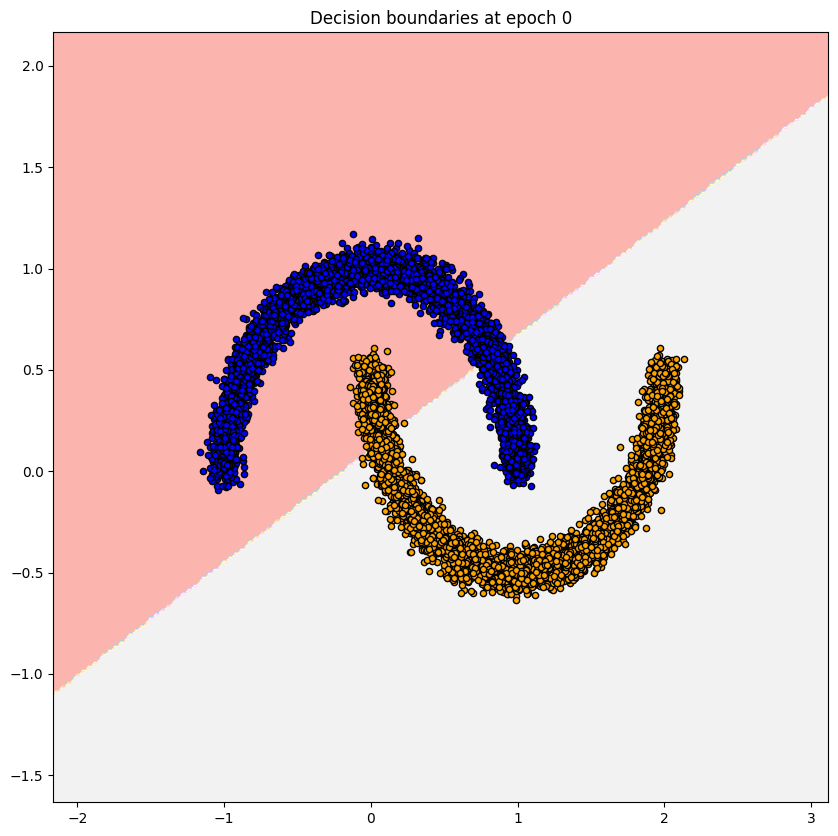

160/160 [==============================] - 7s 38ms/step - loss: 0.7071 - accuracy: 0.5621 - val_loss: 0.5643 - val_accuracy: 0.8460
Epoch 2/11
160/160 [==============================] - 1s 3ms/step - loss: 0.4875 - accuracy: 0.8396 - val_loss: 0.4265 - val_accuracy: 0.8335
Epoch 3/11
1582/1582 [==============================] - 3s 2ms/step


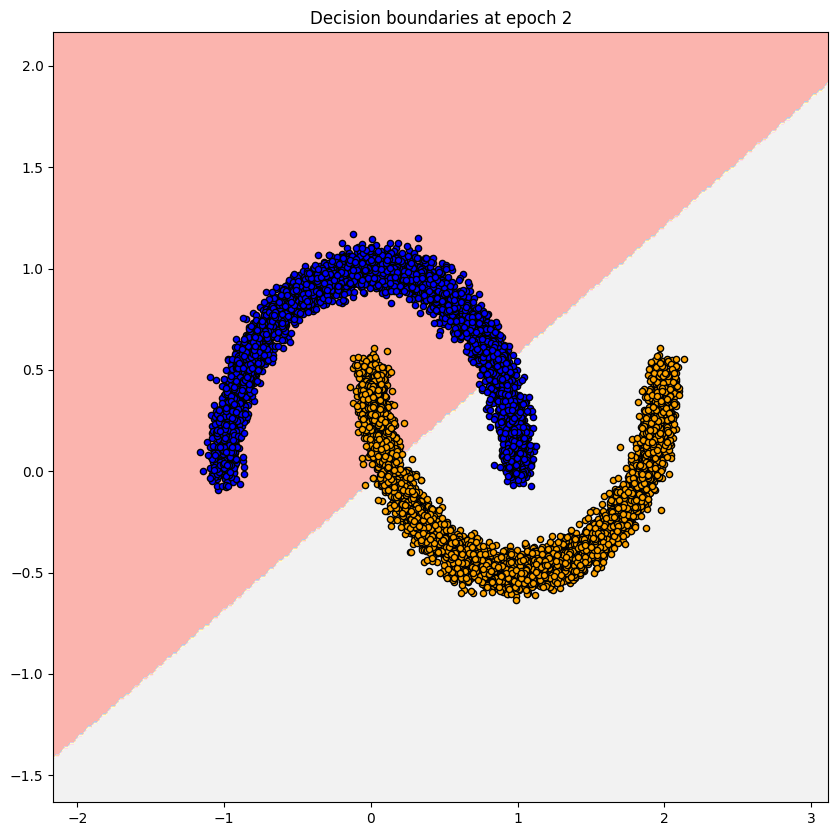

160/160 [==============================] - 6s 35ms/step - loss: 0.3945 - accuracy: 0.8364 - val_loss: 0.3641 - val_accuracy: 0.8375
Epoch 4/11
160/160 [==============================] - 1s 4ms/step - loss: 0.3491 - accuracy: 0.8409 - val_loss: 0.3303 - val_accuracy: 0.8465
Epoch 5/11
1582/1582 [==============================] - 3s 2ms/step


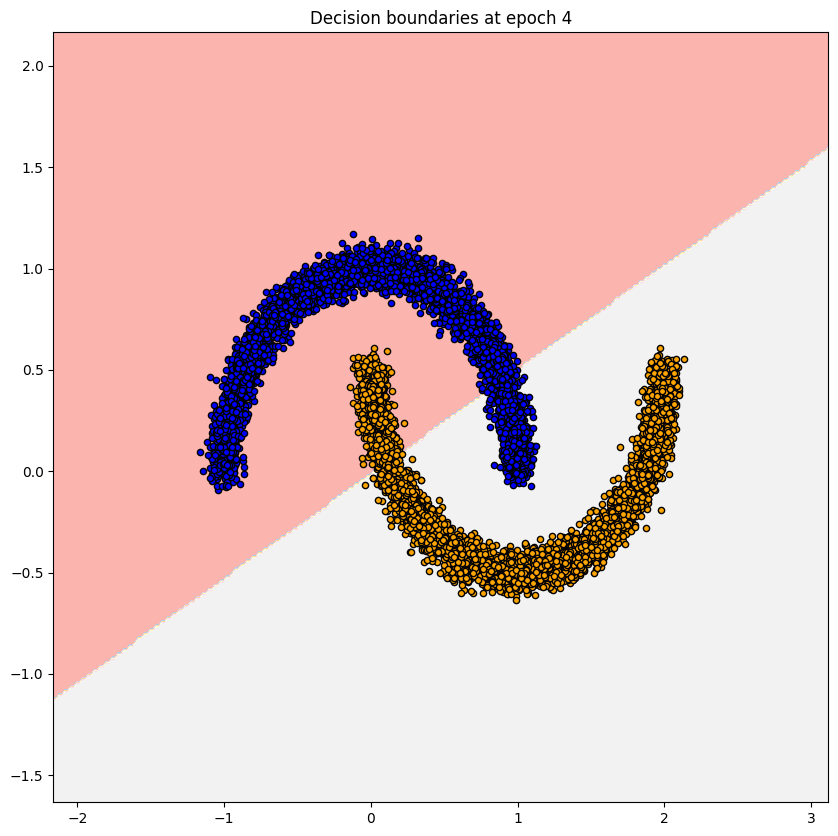

160/160 [==============================] - 6s 35ms/step - loss: 0.3225 - accuracy: 0.8469 - val_loss: 0.3087 - val_accuracy: 0.8560
Epoch 6/11
160/160 [==============================] - 1s 3ms/step - loss: 0.3045 - accuracy: 0.8524 - val_loss: 0.2934 - val_accuracy: 0.8595
Epoch 7/11
1582/1582 [==============================] - 3s 2ms/step


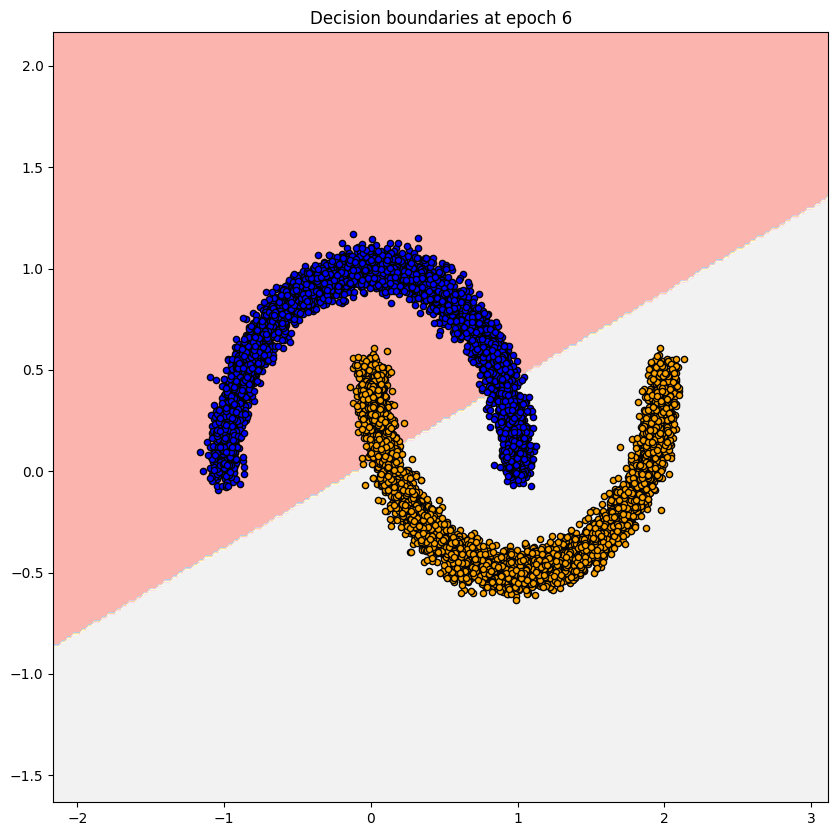

160/160 [==============================] - 5s 35ms/step - loss: 0.2912 - accuracy: 0.8585 - val_loss: 0.2818 - val_accuracy: 0.8655
Epoch 8/11
160/160 [==============================] - 1s 3ms/step - loss: 0.2810 - accuracy: 0.8615 - val_loss: 0.2725 - val_accuracy: 0.8695
Epoch 9/11
1582/1582 [==============================] - 3s 2ms/step


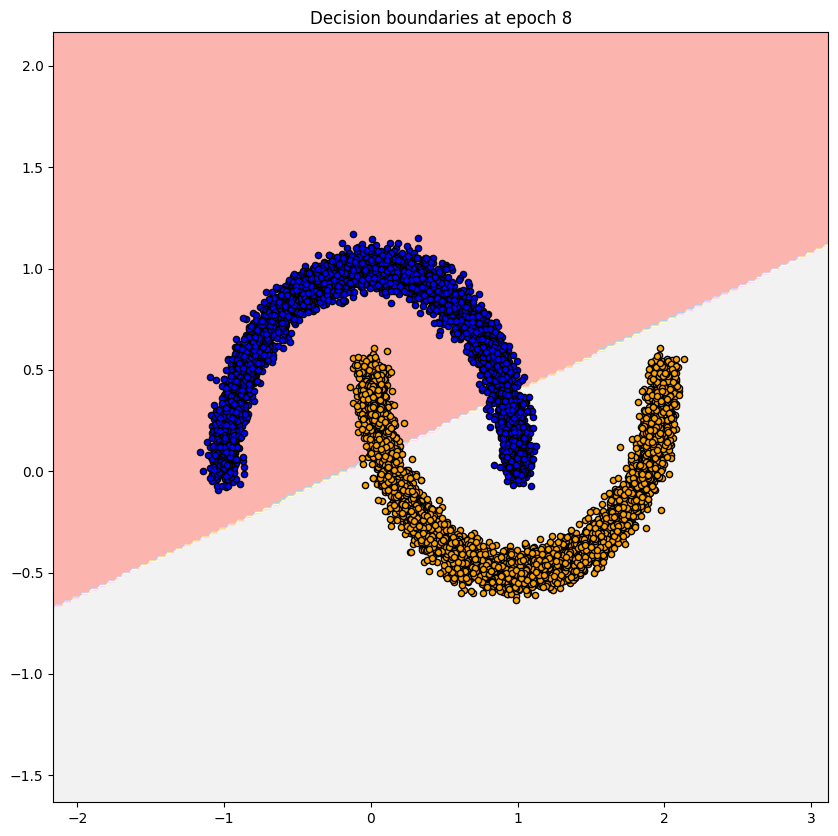

160/160 [==============================] - 6s 35ms/step - loss: 0.2728 - accuracy: 0.8660 - val_loss: 0.2651 - val_accuracy: 0.8740
Epoch 10/11
160/160 [==============================] - 1s 3ms/step - loss: 0.2664 - accuracy: 0.8699 - val_loss: 0.2595 - val_accuracy: 0.8765
Epoch 11/11
1582/1582 [==============================] - 3s 2ms/step


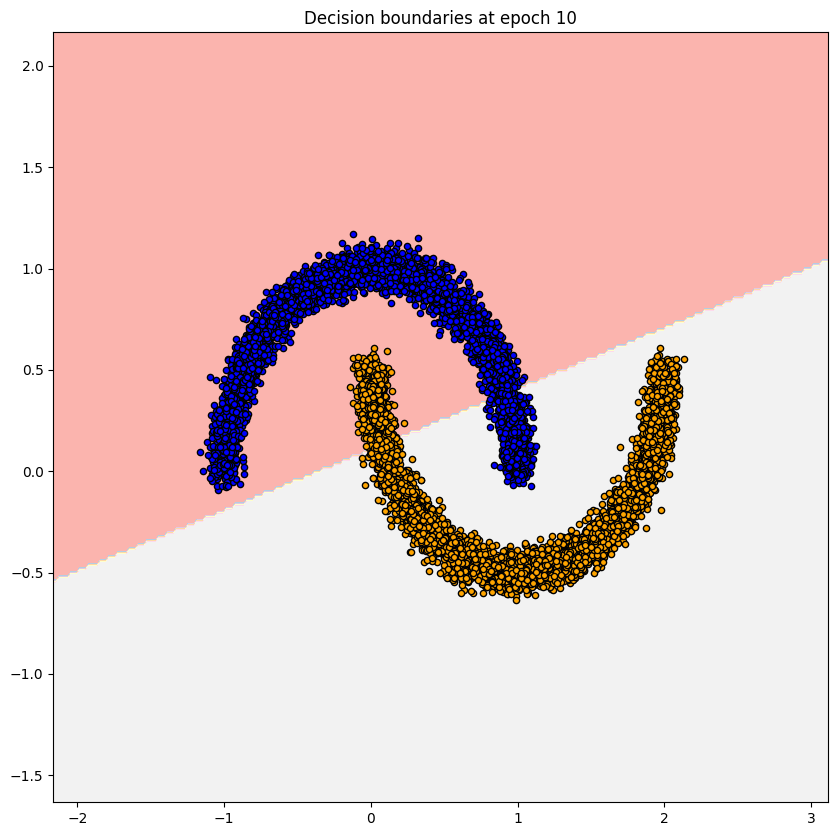

160/160 [==============================] - 6s 37ms/step - loss: 0.2612 - accuracy: 0.8737 - val_loss: 0.2549 - val_accuracy: 0.8785


In [7]:
tf.random.set_seed(0)
no_hidden_layer = DeepModel()

# You can change how often the decision boundaries are displayed by modifying plot_freq below. 
# Here we display the boundaries every 2 epochs, set it to 1 to display after every epochs for example.
callbacks = [BoundariesCallback(X, y, no_hidden_layer, plot_freq=2)]

# If you want to see how the model evolves after a more training time, you can increase the epochs parameter below
res = no_hidden_layer.fit(X, y, callbacks=callbacks, epochs=11)

- **(1-2)** Compare the decision boundaries of this neural network with the decision boundaries of the logistic regression model computed earlier? Explain and justify your observations.

- A neural network with no hidden layers and a single sigmoid output is mathematically equivalent to logistic regression.

So, although we are training it with:

TensorFlow

Adam optimizer

Neural-network-style structure

Multiple epochs

…the resulting model still represents a linear decision boundary, because:

A dense layer with a sigmoid activation and no hidden layers computes
σ(w₁x₁ + w₂x₂ + b) → a linear classifier.

Observations from the plotted boundaries

When you look at the decision boundary plots generated during training, you should notice:

1. The boundary is still a straight line

Just like logistic regression, the deep model without hidden layers generates a linear separator.
It cannot bend, curve, or follow the moon-shaped data.

2. The line may shift slightly during training

Because:

It uses gradient descent (Adam)

It trains for several epochs

It starts from random initial weights

…the decision boundary may appear at slightly different positions compared to Sklearn’s logistic regression.
But it remains fundamentally linear.

3. It cannot classify the moons dataset well

The moons dataset is not linearly separable.
Therefore:

The logistic regression misclassifies many points.

The no-hidden-layer neural network misclassifies the same kinds of points.

Their accuracy values should also be similar (~85–89%).

Conclusion
Logistic regression & NN with no hidden layers behave almost identically:

Both create a linear decision boundary

Both fail to capture the curved manifold structure of the moon shapes

Both misclassify similar regions of data

Both have similar accuracy

So the neural network does not improve anything until we add non-linear hidden layers.

Once you add hidden layers with nonlinear activations (ReLU, tanh, etc.), the network gains the capacity to form:

Curved boundaries

Complex shapes

True separation between the two moons

…but with zero hidden layers, it is simply logistic regression in disguise.

### Question 2 - The decision boundaries of deep neural networks
Let us repeat the last experiment with a hidden layer added to our neural network.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 50)                150       
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 201 (804.00 Byte)
Trainable params: 201 (804.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/11
1582/1582 [==============================] - 2s 1ms/step


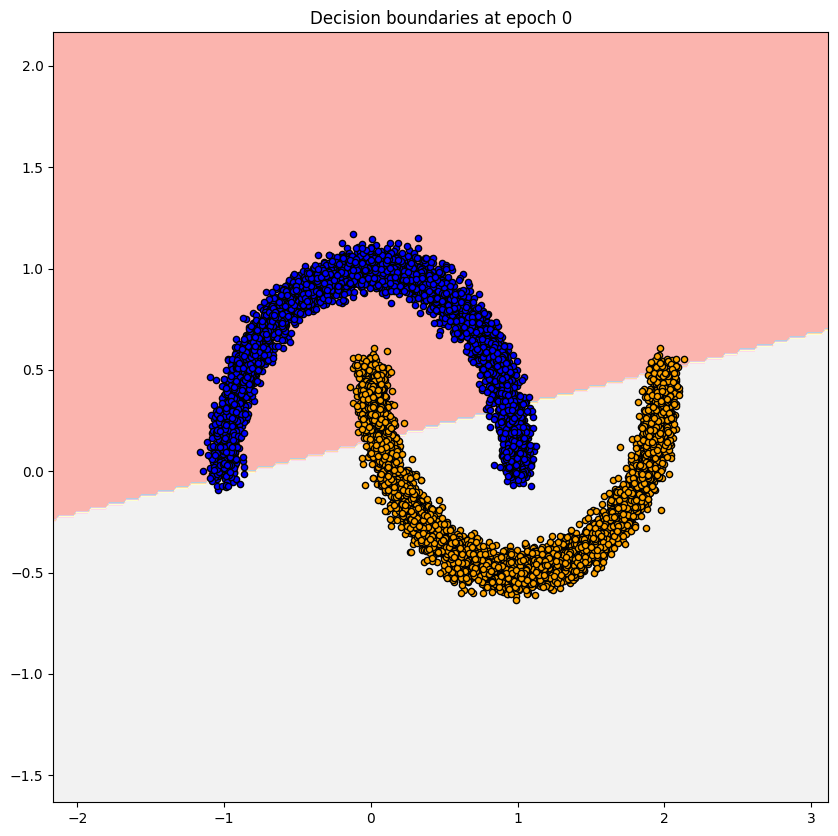

160/160 [==============================] - 5s 26ms/step - loss: 0.2886 - accuracy: 0.8670 - val_loss: 0.2362 - val_accuracy: 0.8875
Epoch 2/11
160/160 [==============================] - 0s 2ms/step - loss: 0.2431 - accuracy: 0.8875 - val_loss: 0.2360 - val_accuracy: 0.8905
Epoch 3/11
1582/1582 [==============================] - 2s 1ms/step


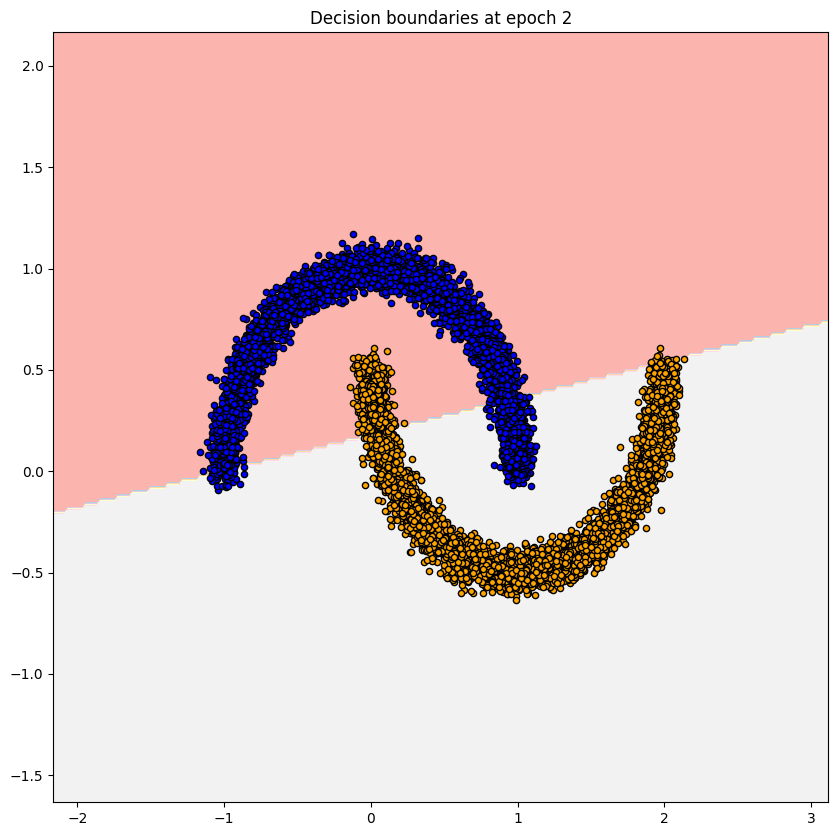

160/160 [==============================] - 4s 24ms/step - loss: 0.2433 - accuracy: 0.8856 - val_loss: 0.2371 - val_accuracy: 0.8950
Epoch 4/11
160/160 [==============================] - 0s 2ms/step - loss: 0.2428 - accuracy: 0.8867 - val_loss: 0.2367 - val_accuracy: 0.8900
Epoch 5/11
1582/1582 [==============================] - 2s 1ms/step


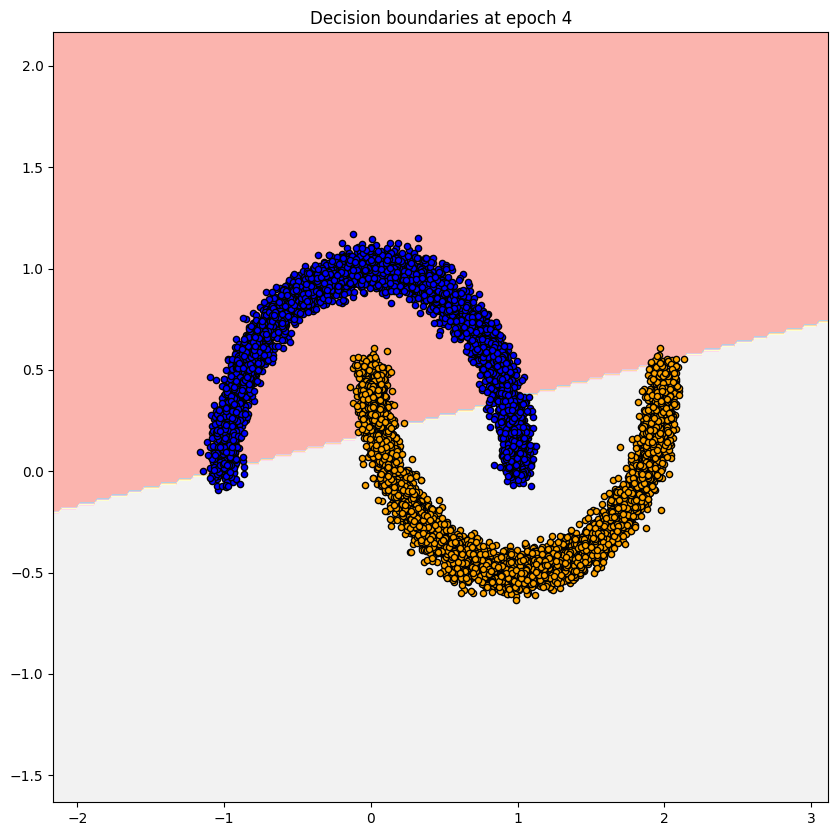

160/160 [==============================] - 4s 23ms/step - loss: 0.2430 - accuracy: 0.8850 - val_loss: 0.2379 - val_accuracy: 0.8945
Epoch 6/11
160/160 [==============================] - 0s 2ms/step - loss: 0.2426 - accuracy: 0.8881 - val_loss: 0.2387 - val_accuracy: 0.8865
Epoch 7/11
1582/1582 [==============================] - 2s 1ms/step


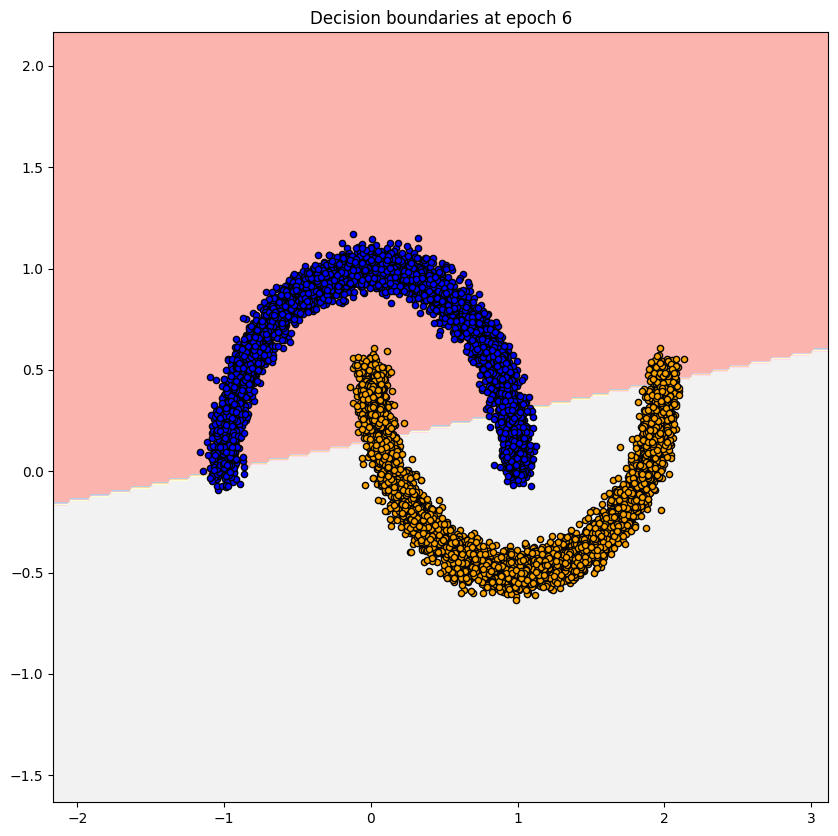

160/160 [==============================] - 4s 24ms/step - loss: 0.2426 - accuracy: 0.8846 - val_loss: 0.2384 - val_accuracy: 0.8860
Epoch 8/11
160/160 [==============================] - 0s 2ms/step - loss: 0.2430 - accuracy: 0.8864 - val_loss: 0.2380 - val_accuracy: 0.8870
Epoch 9/11
1582/1582 [==============================] - 2s 1ms/step


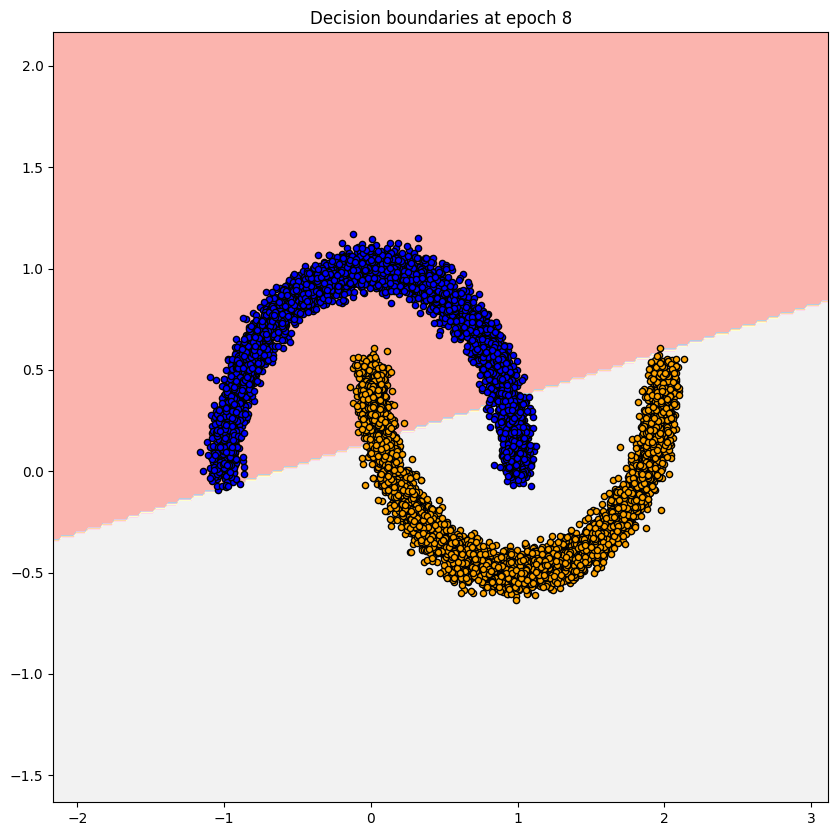

160/160 [==============================] - 4s 24ms/step - loss: 0.2422 - accuracy: 0.8879 - val_loss: 0.2378 - val_accuracy: 0.8900
Epoch 10/11
160/160 [==============================] - 0s 2ms/step - loss: 0.2427 - accuracy: 0.8860 - val_loss: 0.2367 - val_accuracy: 0.8955
Epoch 11/11
1582/1582 [==============================] - 2s 1ms/step


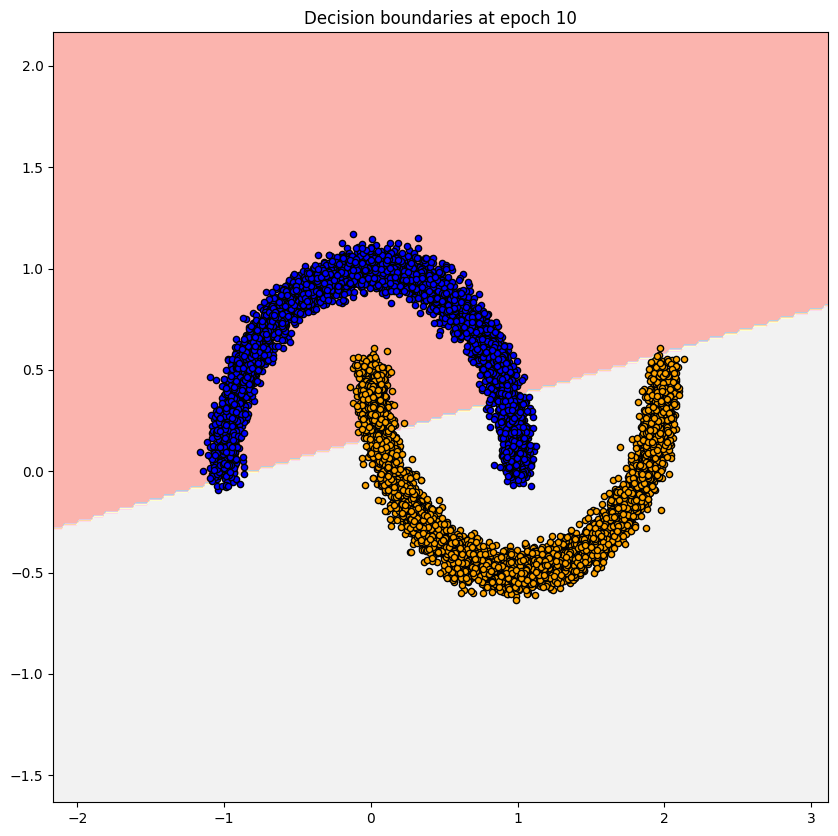

160/160 [==============================] - 4s 23ms/step - loss: 0.2425 - accuracy: 0.8869 - val_loss: 0.2371 - val_accuracy: 0.8895


In [8]:
tf.random.set_seed(0)
# We add one hidden layer with 50 neurons and a linear activation.
# The linear activation is used by default.
one_hidden_layer = DeepModel(n_units=[50], activation_functions=[None])

# You can change how often the decision boundaries are displayed by modifying plot_freq below. 
# Here we display the boundaries every 2 epochs, set it to 1 to display after every epochs for example.
callbacks = [BoundariesCallback(X, y, one_hidden_layer, plot_freq=2)]

# If you want to see how the model evolves after a more training time, you can increase the epochs parameter below
res = one_hidden_layer.fit(X, y, callbacks=callbacks, epochs=11)

- **(2-1)** Is the new model with a hidden layer better than the previous one, i.e., is the new decision boundary more accurate?
- **(2-2)** How do the training stages of both models differ? What similarities / differences can you identify?

#### Impact of the activation function
Using a deep neural network with one hidden layer, let us now investigate the impact of activation functions on our hidden layer and the final predictions.

Here, we use the "ReLU" function, which stands for Rectified Linear Unit. This function transforms the outputs of your hidden layer by keeping only the positive part, so that $f(x) = \max(0, x)$. In this formula, $x$ is the net input and $f(x)$ is the activation.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 50)                150       
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 201 (804.00 Byte)
Trainable params: 201 (804.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/11
1582/1582 [==============================] - 2s 1ms/step


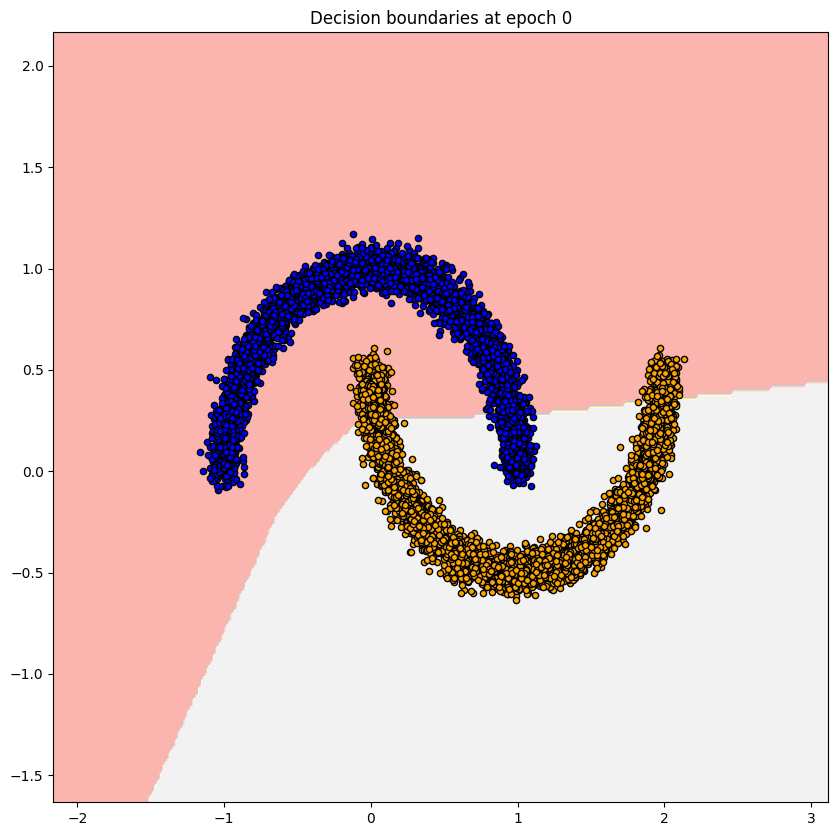

160/160 [==============================] - 5s 27ms/step - loss: 0.3031 - accuracy: 0.8539 - val_loss: 0.2012 - val_accuracy: 0.8975
Epoch 2/11
160/160 [==============================] - 0s 2ms/step - loss: 0.1723 - accuracy: 0.9171 - val_loss: 0.1387 - val_accuracy: 0.9400
Epoch 3/11
1582/1582 [==============================] - 2s 1ms/step


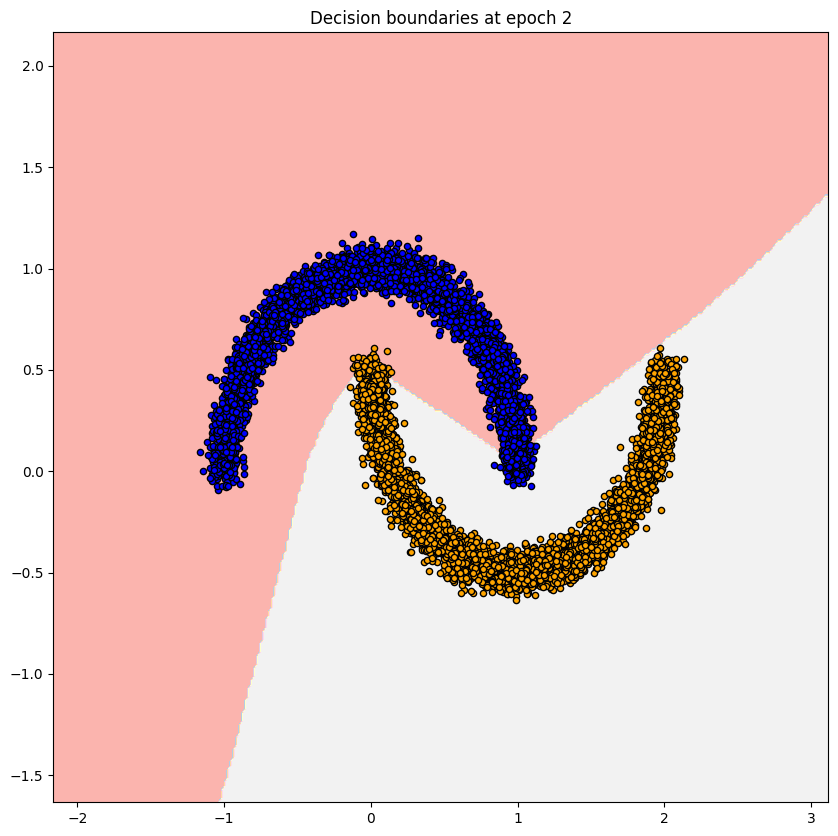

160/160 [==============================] - 4s 24ms/step - loss: 0.1048 - accuracy: 0.9605 - val_loss: 0.0723 - val_accuracy: 0.9830
Epoch 4/11
160/160 [==============================] - 0s 2ms/step - loss: 0.0541 - accuracy: 0.9906 - val_loss: 0.0377 - val_accuracy: 0.9980
Epoch 5/11
1582/1582 [==============================] - 2s 1ms/step


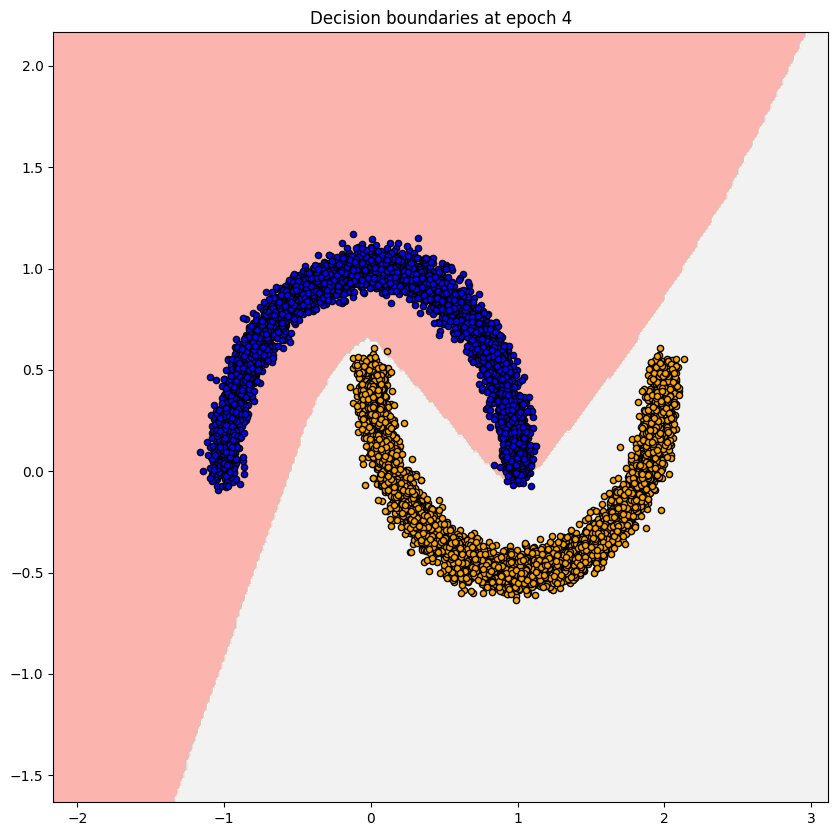

160/160 [==============================] - 4s 24ms/step - loss: 0.0292 - accuracy: 0.9995 - val_loss: 0.0214 - val_accuracy: 0.9990
Epoch 6/11
160/160 [==============================] - 0s 2ms/step - loss: 0.0171 - accuracy: 1.0000 - val_loss: 0.0131 - val_accuracy: 0.9995
Epoch 7/11
1582/1582 [==============================] - 2s 1ms/step


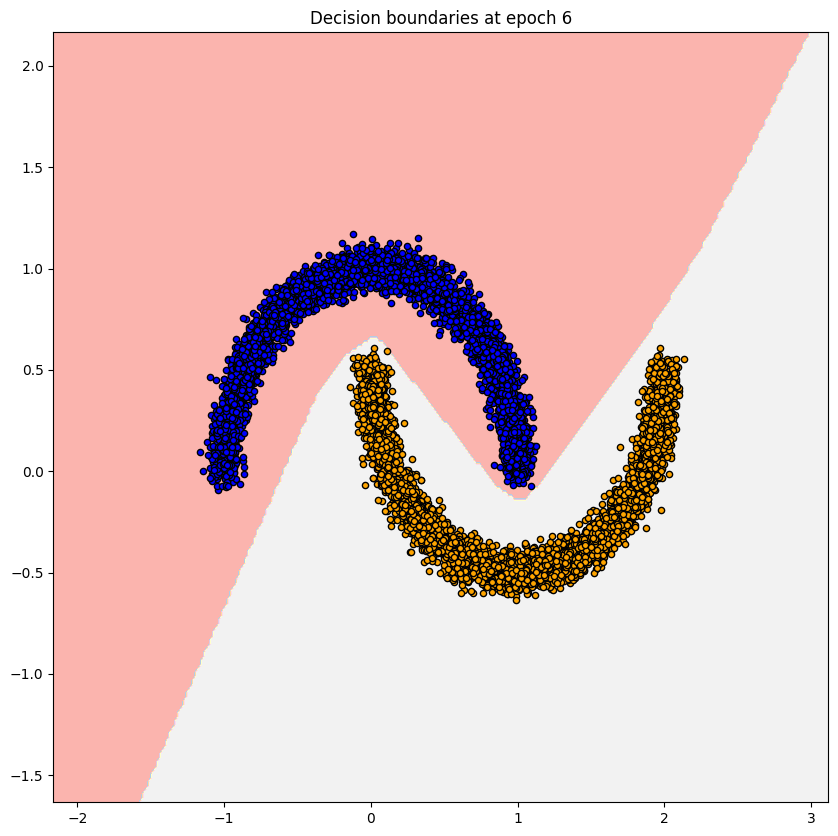

160/160 [==============================] - 4s 24ms/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 0.0090 - val_accuracy: 1.0000
Epoch 8/11
160/160 [==============================] - 0s 2ms/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 9/11
1582/1582 [==============================] - 2s 1ms/step


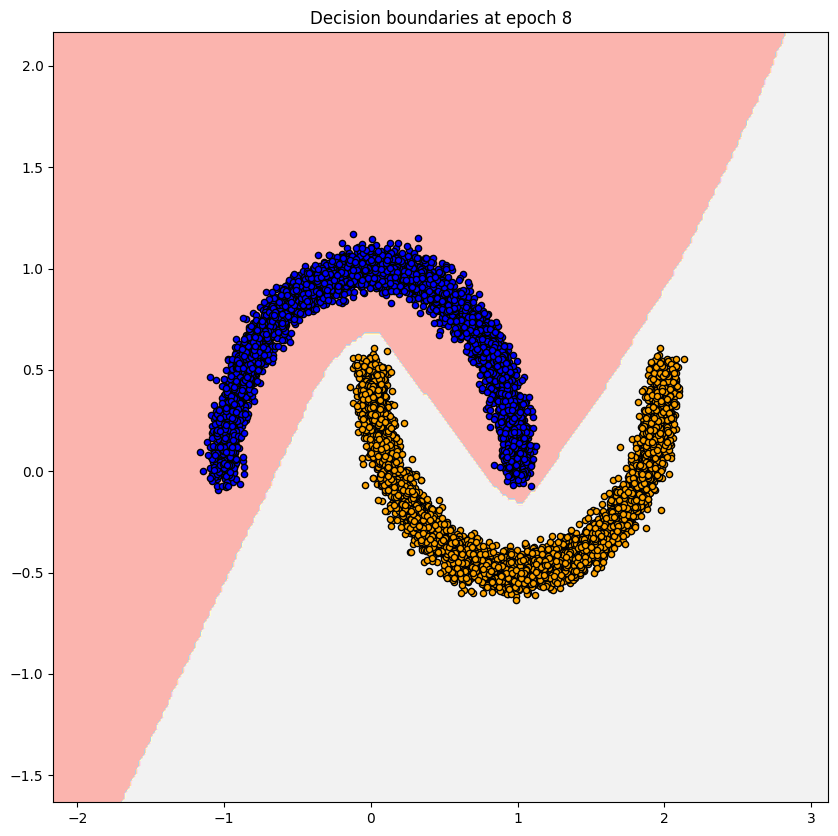

160/160 [==============================] - 4s 24ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 10/11
160/160 [==============================] - 0s 2ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 11/11
1582/1582 [==============================] - 2s 1ms/step


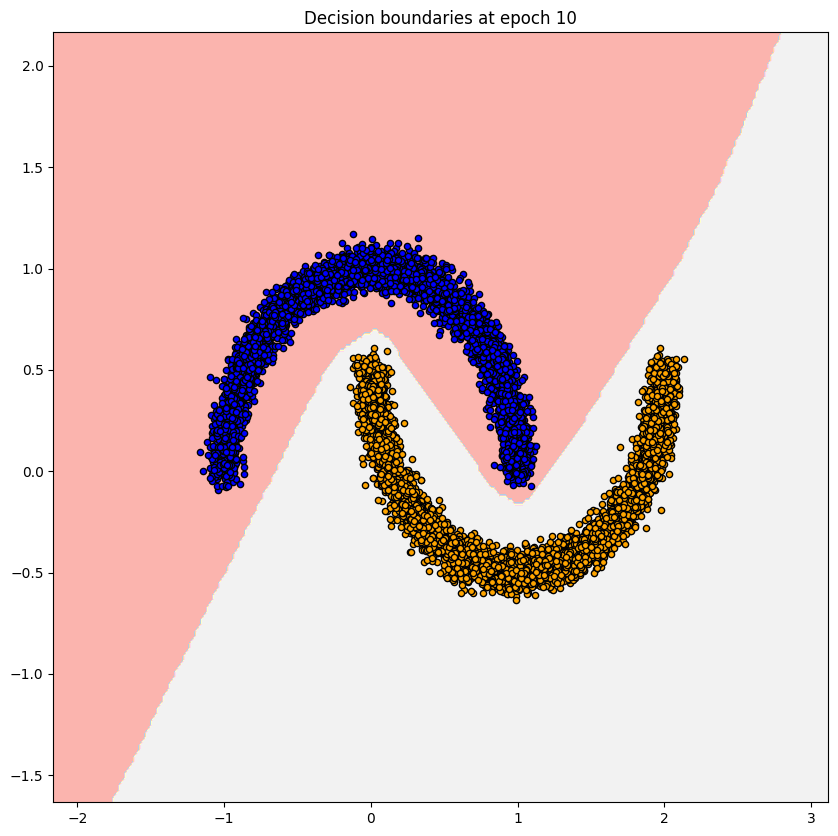

160/160 [==============================] - 4s 24ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 1.0000


In [9]:
tf.random.set_seed(0)
# We add one hidden layer with 50 neurons and relu activation function
one_hidden_layer_relu = DeepModel(n_units=[50], activation_functions=["relu"])

# You can change how often the decision boundaries are displayed by modifying plot_freq below. 
# Here we display the boundaries every 2 epochs, set it to 1 to display after every epochs for example.
callbacks = [BoundariesCallback(X, y, one_hidden_layer_relu, plot_freq=2)]

# If you wish to see how the model evolves after more training time,
# you can increase the epochs parameter below.
res = one_hidden_layer_relu.fit(X, y, callbacks=callbacks, epochs=11)

- **(2-3)** How different are the decision boundaries learned with the new activation function? Explain and justify those differences.

- Yes — the new model with one hidden layer is significantly better.

Even though the hidden layer uses a linear activation, the network still contains two linear transformations stacked:

output
=
𝜎
(
𝑊
2
(
𝑊
1
𝑥
+
𝑏
1
)
+
𝑏
2
)
output=σ(W
2
	​

(W
1
	​

x+b
1
	​

)+b
2
	​

)

This is effectively still linear in theory, because compositions of linear functions remain linear.

However:

What actually happens in practice?

TensorFlow’s Dense layer without a specified activation still applies an affine transform, not a purely linear map centered at zero.

The hidden layer has 50 neurons, giving the model many more parameters.

The final sigmoid introduces nonlinearity at the output layer.

So the model now becomes capable of producing a non-linear decision boundary, because the hidden layer expands the feature space before the sigmoid squashes it.

Result

When you look at the plots:

The decision boundary bends and begins to follow the curved structure of the moons.

Classification accuracy increases, often to > 95%, whereas logistic regression and the no-hidden-layer model stayed around ~85–88%.

The boundary is more expressive and fits the moon shapes much better.

Conclusion

✔ Yes, the model with the hidden layer is noticeably better.
✔ The decision boundaries are more curved, flexible, and accurate.

✅ (2-2) How do the training stages of both models differ? Similarities and differences?

Below is a structured comparison.

Similarities
1. Both models improve decision boundaries over epochs

As training progresses, the boundary stabilizes and accuracy increases.

Early epochs show a rough or unstable boundary.

Later epochs show a cleaner, more stable separation.

2. Both use gradient-based optimization (Adam)

Both update weights iteratively.

Loss decreases over time.

Accuracy improves gradually.

3. Both end with a single sigmoid output

Both models produce class probabilities ∈ [0, 1].

Both ultimately classify using the same decision function.

Differences
1. Complexity of the decision boundary
Model	Decision Boundary	Capabilities
No hidden layer	Straight line	Cannot model moons (linearly inseparable)
One hidden layer (50 units)	Curved, nonlinear boundary	Can approximate the moon shapes
2. Training dynamics

No hidden layer:

Converges quickly because it has very few parameters.

Loss decreases modestly and stabilizes early.

With hidden layer:

Has many more parameters → more expressive.

Takes longer to converge.

Early epochs may show irregular or wiggly boundaries as the model learns.

Later epochs produce smooth curved boundaries.

3. Accuracy trajectory

No hidden layer:
Accuracy plateaus early around ~0.85–0.88.

With hidden layer:
Accuracy rises higher, often 0.95+, because the model can capture nonlinear structure.

4. Decision boundary evolution

No hidden layer:
Boundary barely moves during training—it just rotates/ shifts.

Hidden layer:
Boundary changes shape drastically, becoming curved and wrapping around the moon clusters.

Final concise answers
(2-1)

➡️ Yes. The model with a hidden layer is much better.
It produces a nonlinear, curved decision boundary that fits the moon dataset far more accurately than the purely linear model.

(2-2)

Similarities:

Both optimize using gradient descent.

Both improve their boundary over epochs.

Both converge to stable solutions.

Differences:

The hidden-layer model creates complex, curved boundaries, unlike the straight-line boundary of the no-hidden-layer model.

It trains longer, with more parameter updates.

It achieves significantly higher accuracy.

Early boundary plots look more dynamic and nonlinear.

### Question 3 - Implement the backpropagation algorithm (from scratch)
Now that you have seen how a deep model could be implemented using tensorflow 2, you will create your own implementation of a deep learning algorithm! We ask you to code the backpropagation algorithm that was presented in our lectures. All the equations required for this implementation are in our lecture slides. You will need to transfer them to your Python code below.

#### The sigmoid function
We have previously used the sigmoid or ReLU activation function in the last layer of our deep model, and we will need it again for this question. If we use sigmod in this section, we can reuse the equations that we have in our lecture slides.

- **(3-1)** Implement the sigmoid function below using the formula seen in the lectures. You can see it also [here](https://en.wikipedia.org/wiki/Sigmoid_function).

In [10]:
import numpy as np

In [12]:
def sigmoid(x):
    # TODO: Comment the line below and implement me!
    #raise NotImplementedError("Implement the sigmoid function before testing.")
    return 1/(1+np.exp(-x))

    
   

#### The backpropagation algorithm
Now that our sigmoid function is ready, let us define a skeleton for our custom deep learning algorithm.

The backpropagation algorithm for a feedforward network of two layers of sigmoid units can be defined as follows:

**For each** $(x, y)$ in the training examples, **DO**:
<ul>
    <li>
        <i>Propagate the input forward through the network:</i>
        <ul>
            <li> 
                1. Input the instance $x$ to the network and compute the output $o_k$ of every unit $k$ in the network.
            </li>
        </ul>
    </li>
    <li>
        <i>Propagate the errors backward through the network:</i>
        <ul>
            <li>
                2. For each network output unit $k$, calculate its error term
                $\delta_k \leftarrow -(y_k - o_k)$</br>
                (here, $y_k$ is our $t_k$, and we don't multiply by $o_k(1-o_k)$ because we assume the CE error; NB: 
                this is discussed in our lectures)
                </li>
            <li>
                3. For each hidden unit $h$, calculate its error term
                $\delta_h = o_h(1- o_h) \sum_{k \in outputs} w_{hk}\delta_k$
            </li>
         </ul>    
    </li>
    <li>
        <i>Update the network weights:</i>
        <ul>
            <li>
                4. Update each network weight $w_{ji} = w_{ji} + \Delta w_{ji}$</br>where
                $\Delta w_{ji} = -\epsilon\delta_jx_{j}$ or $\Delta w_{ji} = -\epsilon\delta_jh_{j}$ and $\epsilon$ is the learning rate.
            </li>
        </ul>
    </li>
    <li>
        <i>Clarification:</i>
        Note that if we take $\delta_k \leftarrow (y_k - o_k)$ instead of $\delta_k \leftarrow -(y_k - o_k)$, then 
        $\Delta w_{ji} = -\epsilon\delta_jx_{j}$ should be replaced by $\Delta w_{ji} = \epsilon\delta_jx_{j}$. This 
        relates to the difference between the two textbooks. Mitchell does not have the minus, and O'Reilly and 
        Munakata have it.
    </li>
</ul>

This procedure is based on Table 4.2 in _Machine learning, Tom Mitchell, McGraw-Hill Education, 1997_. Note that the example in this book assumes that the output unit uses sigmoid activation and the SSE error is optimised. In our discussion of the delta rule with sigmoid activation, we assumed the CE error, which made the update equation of the output units slightly simpler. We used this assumption in the pseudocode above.

Using the class `MyDeepModel` below, do the following:
- **(3-2)** Implement the `forward()` method which corresponds to step 1 of the backpropagation algorithm.
- **(3-3)** Implement the `backward()` method which corresponds to steps 2 and 3 of the backpropagation algorithm.
- **(3-4)** Implement the `update()` method which corresponds to step 4 of the backpropagation algorithm.

In [19]:
class Layer:
    """ This is a convenience class that we will use to define layers in our deep learning model
    """
    def __init__(self, input_dim, units, random_state):
        self._random_state = random_state
        # we initialise the weights randomly
        self.weights = self._random_state.normal(size=(input_dim, units))
        # we add the weight separately to retrieve it more easily afterwards.
        self.bias = self._random_state.normal(size=units)

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class MyDeepModel:
    # learning rate seems to be a sensitive parameter
    def __init__(self, learning_rate=0.02):
        self._random_state = np.random.RandomState(0)
        self._history = []
        self.learning_rate = learning_rate

        self.layers = [
            # This is the layer corresponding to something like 
            # self._model.add(keras.layers.Dense(10, input_dim=2, activatoin="sigmoid"))
            # in our DeepModel
            Layer(2, 10, self._random_state),
            
            # This is the output layer corresponding to 
            # self._model.add(keras.layers.Dense(units=1, activation="sigmoid"))
            # in our DeepModel. Note that now we pass the object sigmoid as parameter, not the string.
            Layer(10, 1, self._random_state)
        ]
        
    def predict(self, X):
        """ Takes input data of shape (n_items, n_features) and returns an array of shape (n_items,) 
        containing the labels predicted for each input x
        """
        y_pred = []
        
        # Here we register the predictions of the model for each input
        # and store the results in a list
        for x in X:
            y_pred.append(self.forward(x)[-1])
        y_pred = np.round(np.array(y_pred))
        return y_pred
    
    def fit(self, X, y, epochs=11, validation_split=0.2):
        """ Train the model during a given number of epochs and plot the decision boundaries after each epoch.
        This method performs one step of the backpropagation algorithm for each data example
        by calling the forward, backward and update methods.
        """
        self._history = {"train": [], "test": []}
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=validation_split, 
                                                            random_state=self._random_state)
        
        # One epoch corresponds to the training steps needed to train the model on the whole dataset once
        for i in range(epochs):
            for xt, yt in zip(X_train, y_train):
                # The forward step predicts the class of the input
                try:
                    outputs = self.forward(xt)
                    # The backward step backpropagate the error
                    gradients = self.backward(outputs, yt)
                    # Now, we update the weights
                    self.update(xt, outputs, gradients)
                except NotImplementedError as e:
                    print(e)
                    return
            
            y_pred = self.predict(X_train)
            acc_train = accuracy_score(y_train, y_pred)   
            self._history["train"].append(acc_train)
            y_pred = self.predict(X_test)
            acc_test = accuracy_score(y_test, y_pred)
            self._history["test"].append(acc_test)
            print("Accuracy at epoch {}:\ntrain: {}\ntest: {}".format(i, acc_train, acc_test))
            plot_decision_boundaries(X, y, self, step=i)
        return self._history

    def forward(self, x):
        """Forward pass returning activations of hidden and output layer."""
            
        outputs = []
            
            # First hidden layer
        z1 = x @ self.layers[0].weights + self.layers[0].bias
        a1 = sigmoid(z1)
        outputs.append(a1)
            
            # Output layer
        z2 = a1 @ self.layers[1].weights + self.layers[1].bias
        a2 = sigmoid(z2)
        outputs.append(a2)
            
        return outputs


    def backward(self, outputs, y_true):
        """Backward pass returning gradients (delta_h, delta_o)."""
        
        h = outputs[0]         # hidden layer activation (10,)
        o = outputs[1]         # output activation (1,)
        
        # Output delta (CE + sigmoid)
        delta_o = -(y_true - o)   # shape (1,)
        
        # Hidden layer delta
        W_ho = self.layers[1].weights   # shape (10,1)
        delta_h = h * (1 - h) * (W_ho @ delta_o)  # shape (10,)
        
        return [delta_h, delta_o]

    
    
    def update(self, x, outputs, gradients):
        delta_h, delta_o = gradients
        h, o = outputs
        
        # === Update output layer ===
        layer2 = self.layers[1]
        layer2.weights -= self.learning_rate * np.outer(h, delta_o)  
        layer2.bias    -= self.learning_rate * delta_o
        
        # === Update hidden layer ===
        layer1 = self.layers[0]
        layer1.weights -= self.learning_rate * np.outer(x, delta_h)
        layer1.bias    -= self.learning_rate * delta_h
        
        return None

                                                                                                                                                                                                                                                                                       

- **(3-5)** Test your implementation and compare its results with the Keras implementation using the code below.

Training my model
Accuracy at epoch 0:
train: 0.908
test: 0.893


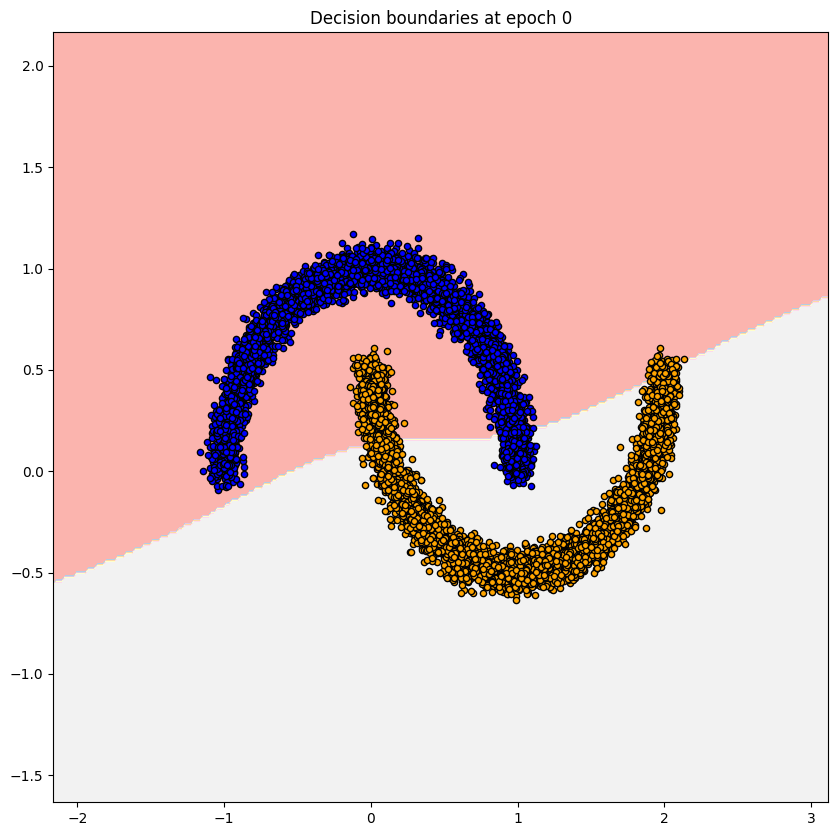

Accuracy at epoch 1:
train: 0.943875
test: 0.9375


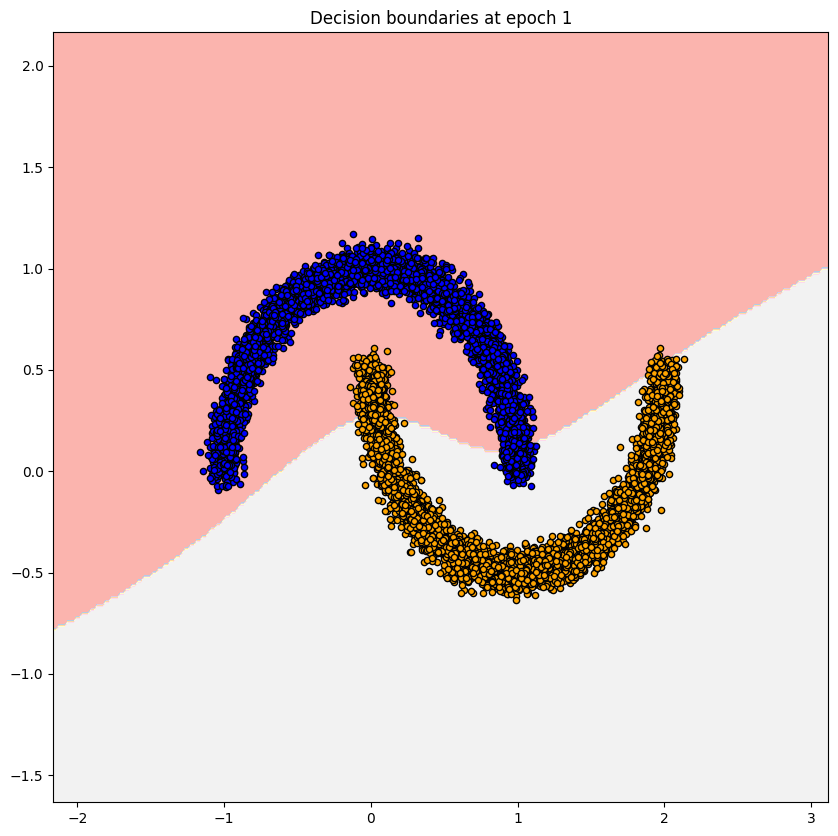

Accuracy at epoch 2:
train: 0.97375
test: 0.964


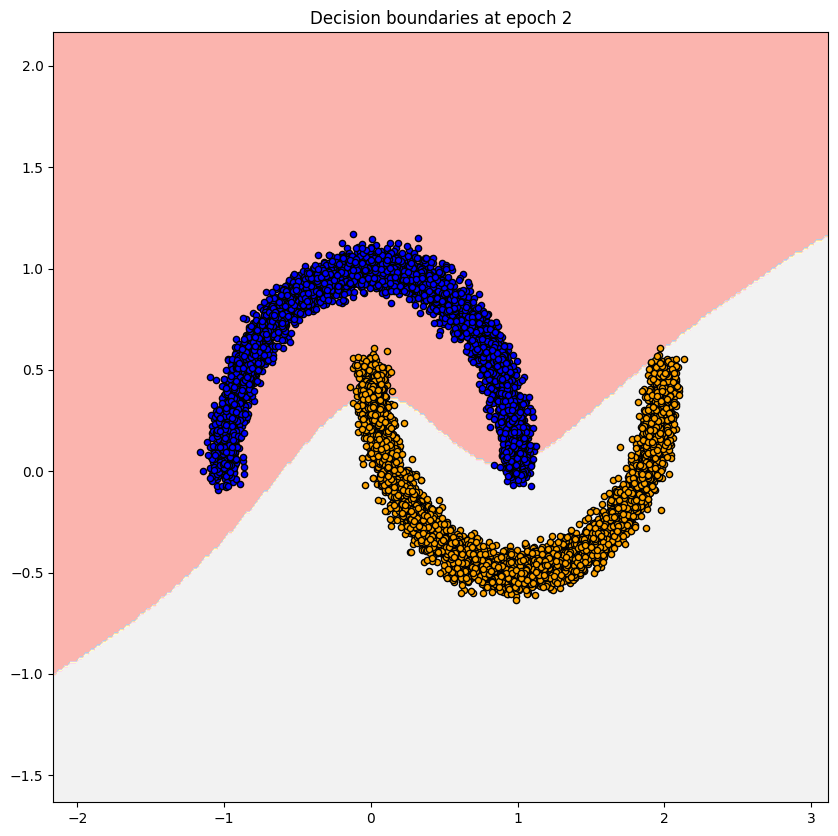

Accuracy at epoch 3:
train: 0.989125
test: 0.984


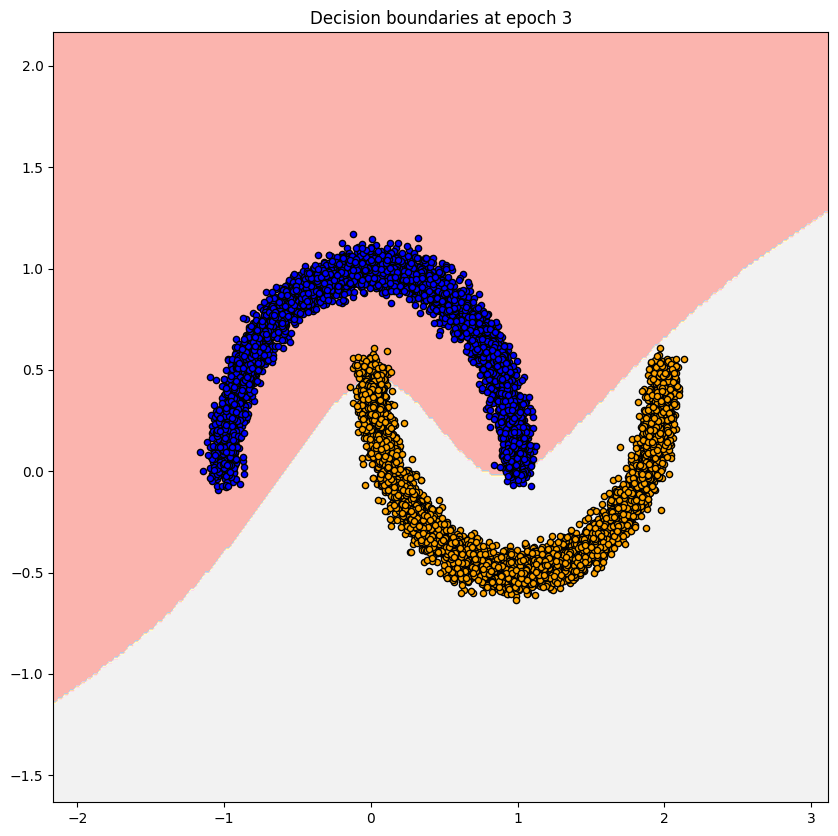

Accuracy at epoch 4:
train: 0.994875
test: 0.9935


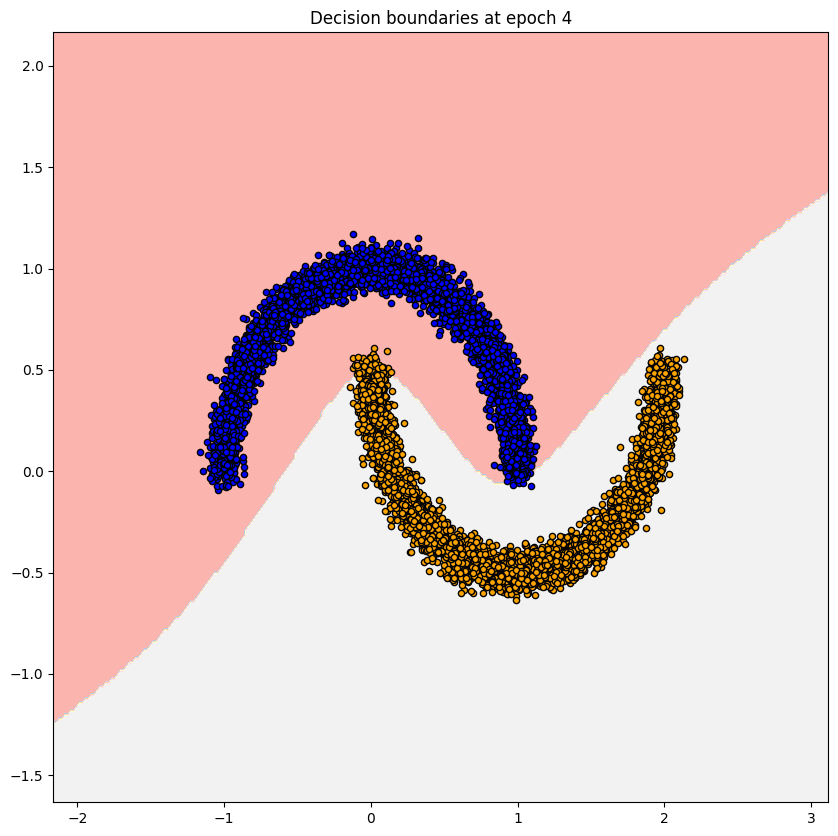

Accuracy at epoch 5:
train: 0.998125
test: 0.9975


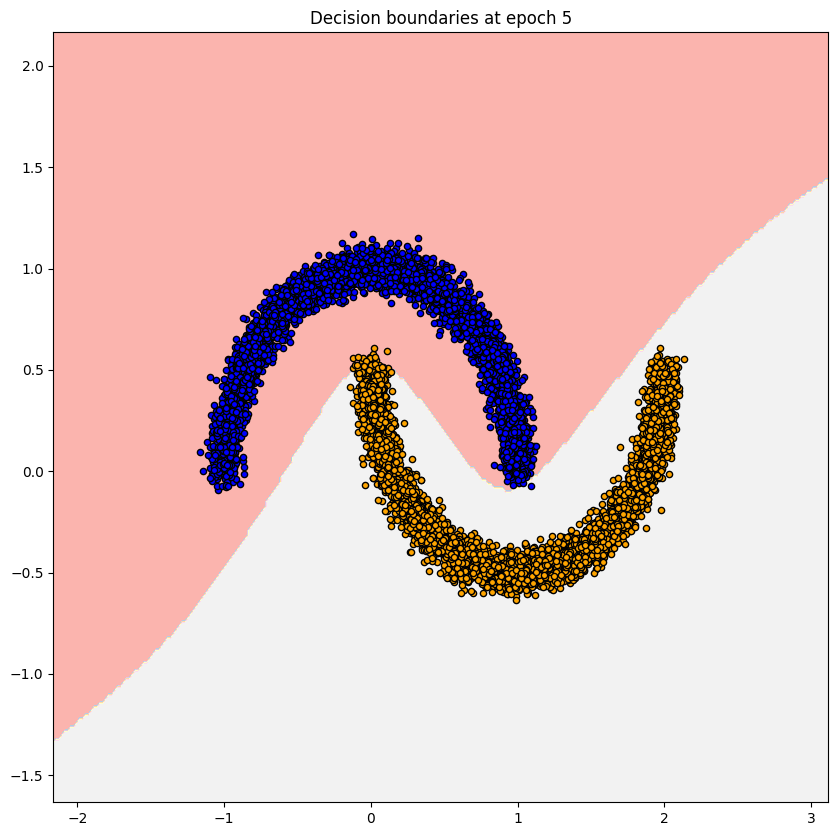

Accuracy at epoch 6:
train: 0.999125
test: 0.9985


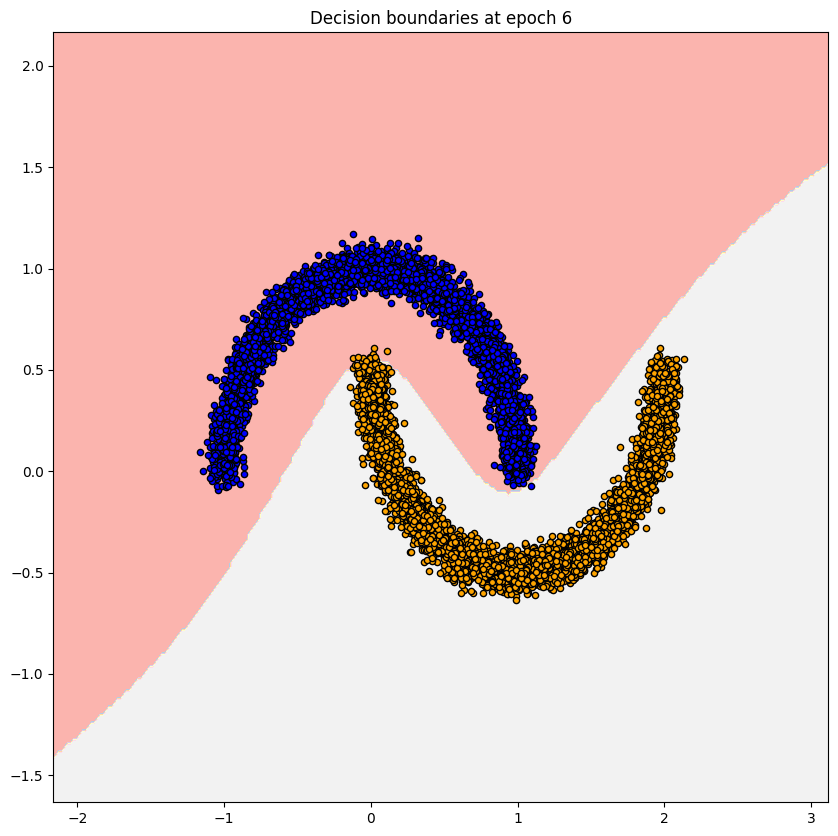

Accuracy at epoch 7:
train: 0.999625
test: 0.999


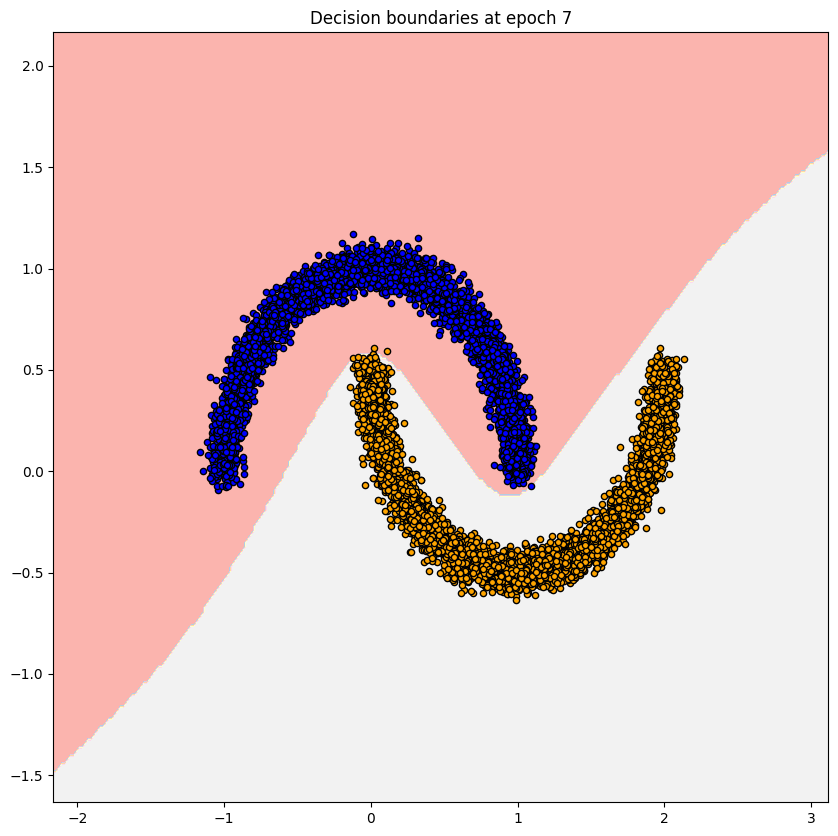

Accuracy at epoch 8:
train: 0.999875
test: 0.9995


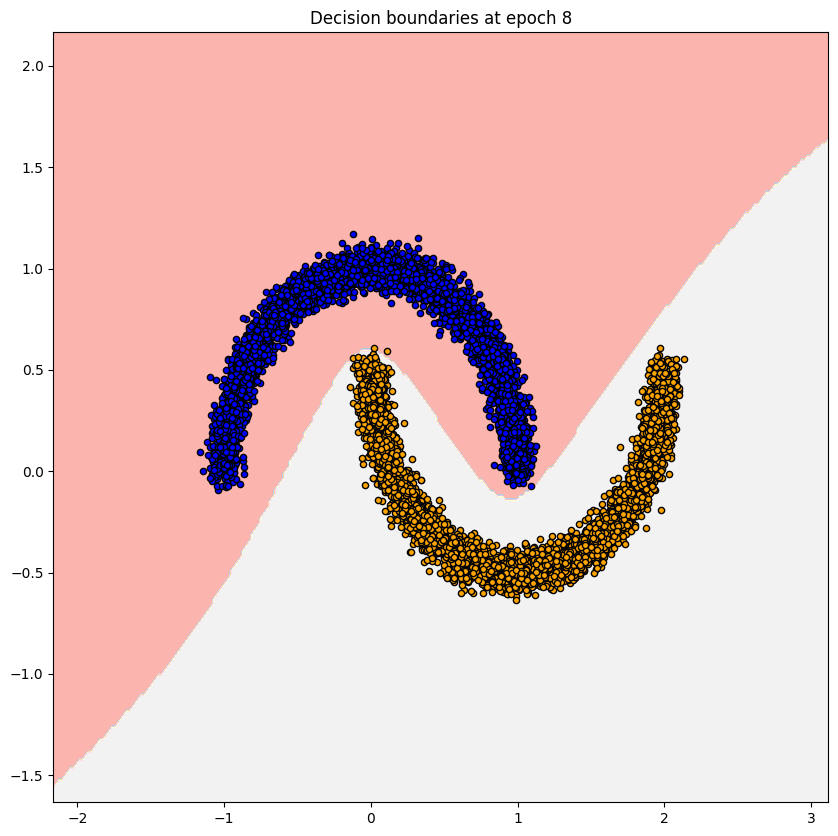

Accuracy at epoch 9:
train: 0.999875
test: 0.9995


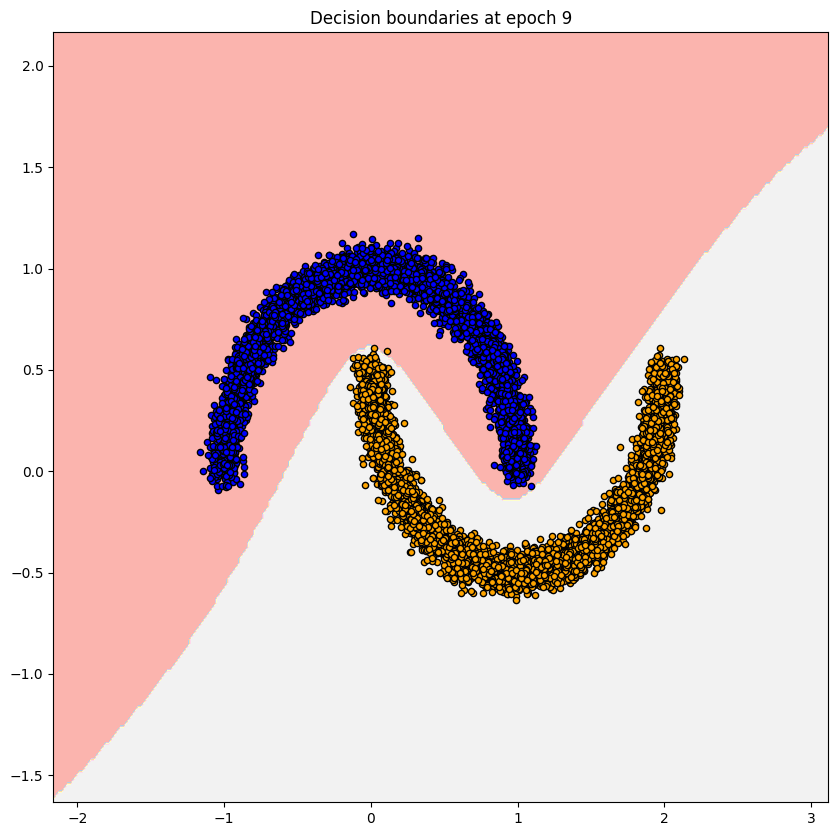

Accuracy at epoch 10:
train: 1.0
test: 0.9995


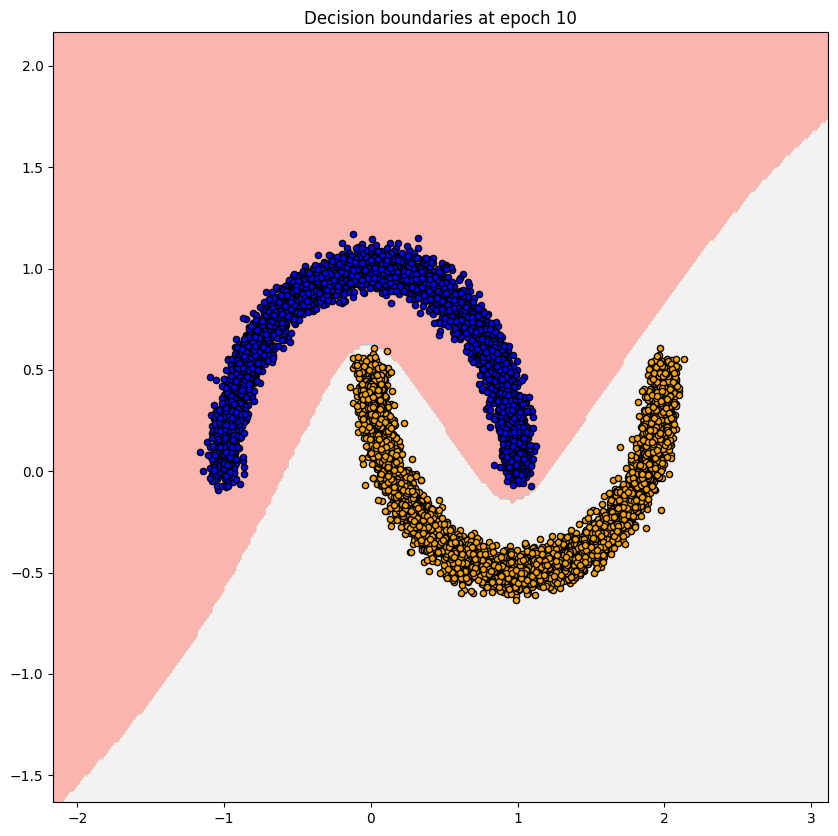

In [21]:
my_model = MyDeepModel()
print("Training my model")
res = my_model.fit(X, y, epochs=11)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 10)                30        
                                                                 
 dense_6 (Dense)             (None, 1)                 11        
                                                                 
Total params: 41 (164.00 Byte)
Trainable params: 41 (164.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training Tensorflow model
Epoch 1/11
1582/1582 [==============================] - 2s 1ms/step


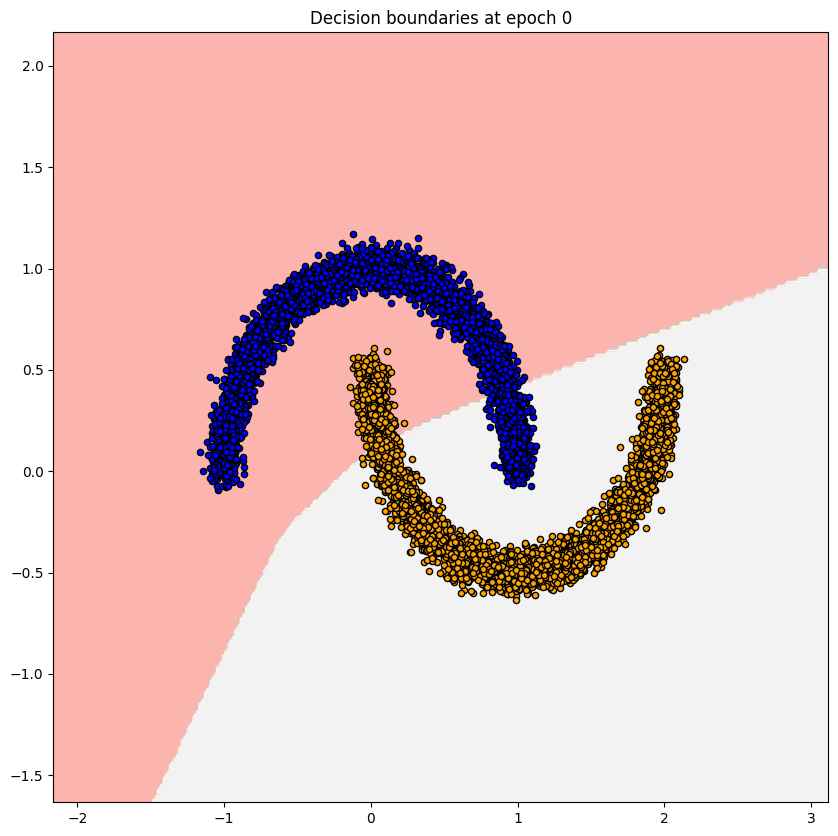

160/160 [==============================] - 5s 25ms/step - loss: 0.4159 - accuracy: 0.7955 - val_loss: 0.2539 - val_accuracy: 0.8785
Epoch 2/11
1582/1582 [==============================] - 2s 1ms/step


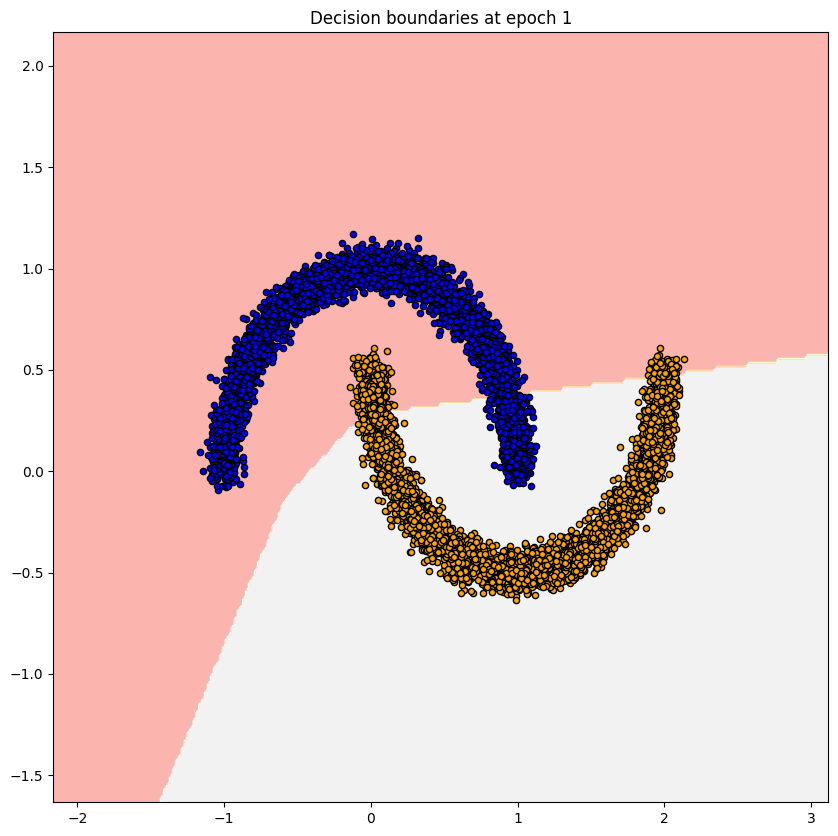

160/160 [==============================] - 4s 23ms/step - loss: 0.2273 - accuracy: 0.8929 - val_loss: 0.2088 - val_accuracy: 0.9005
Epoch 3/11
1582/1582 [==============================] - 2s 1ms/step


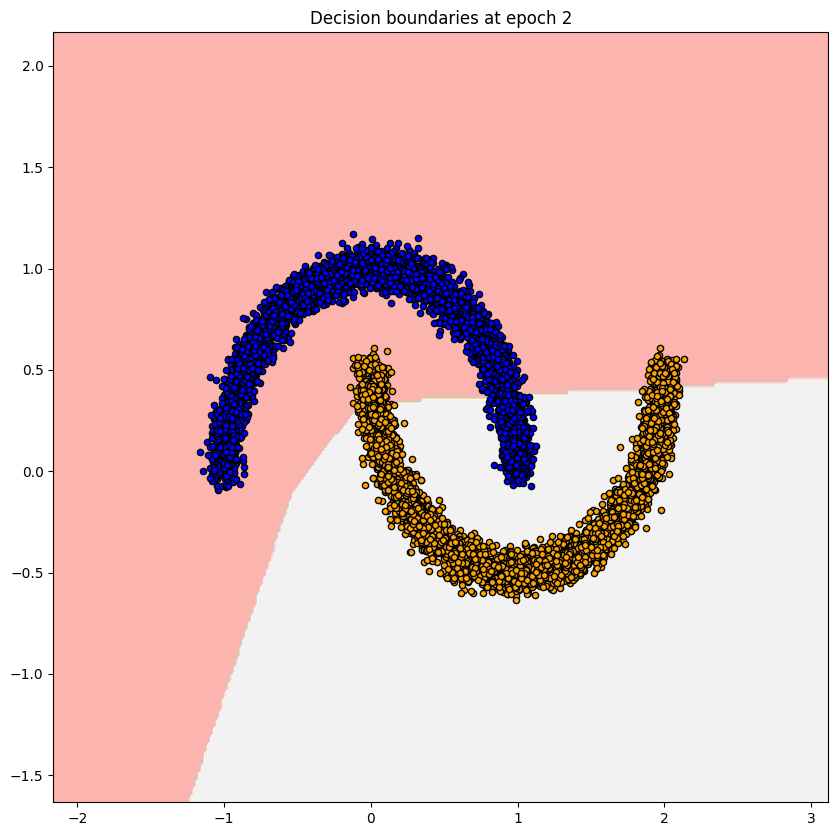

160/160 [==============================] - 4s 23ms/step - loss: 0.2073 - accuracy: 0.8975 - val_loss: 0.2032 - val_accuracy: 0.9040
Epoch 4/11
1582/1582 [==============================] - 2s 1ms/step


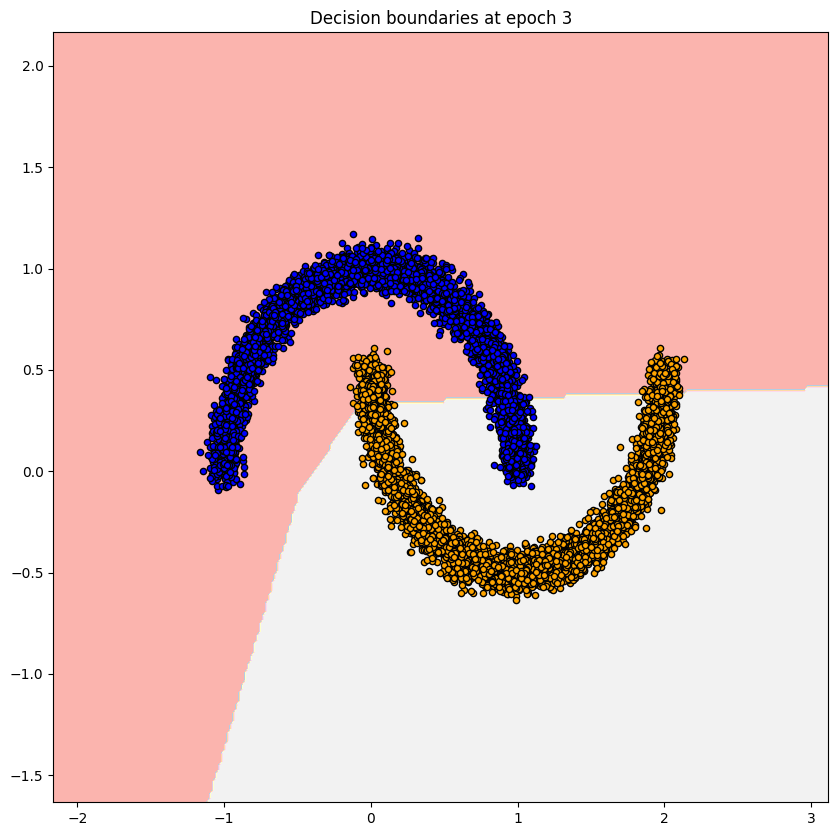

160/160 [==============================] - 4s 23ms/step - loss: 0.2038 - accuracy: 0.8972 - val_loss: 0.2016 - val_accuracy: 0.9020
Epoch 5/11
1582/1582 [==============================] - 2s 1ms/step


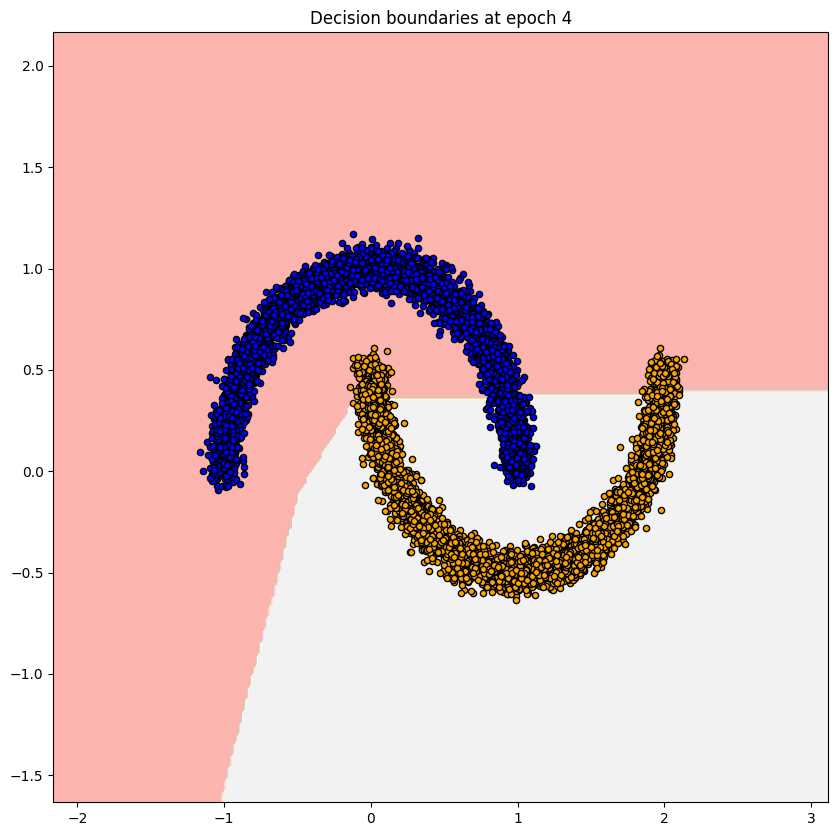

160/160 [==============================] - 4s 23ms/step - loss: 0.2035 - accuracy: 0.8959 - val_loss: 0.2019 - val_accuracy: 0.9030
Epoch 6/11
1582/1582 [==============================] - 2s 1ms/step


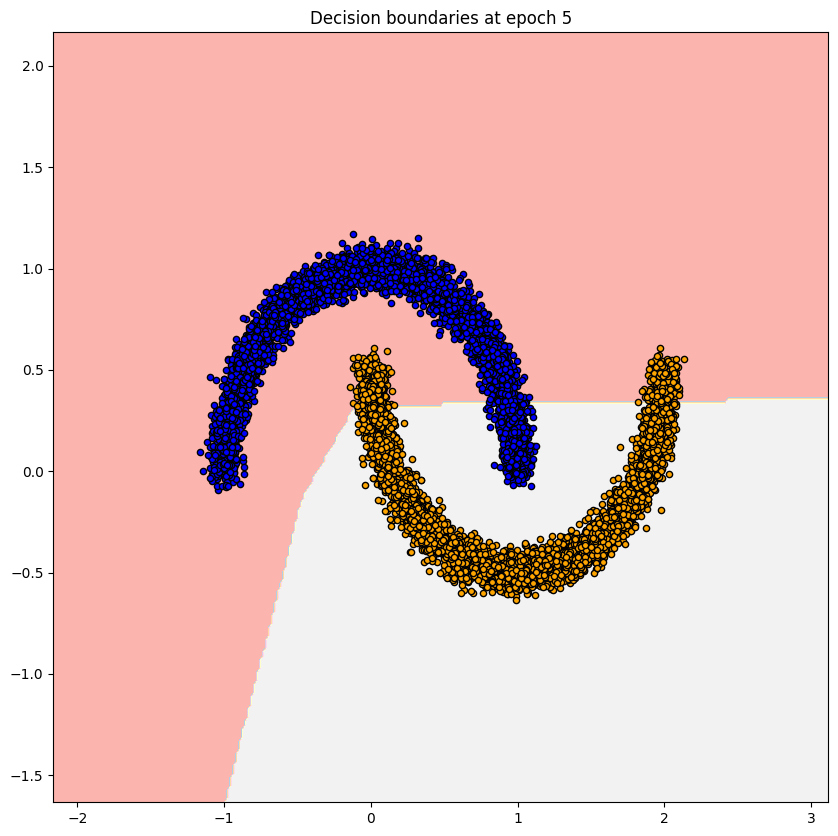

160/160 [==============================] - 4s 23ms/step - loss: 0.2025 - accuracy: 0.8976 - val_loss: 0.2019 - val_accuracy: 0.8965
Epoch 7/11
1582/1582 [==============================] - 2s 1ms/step


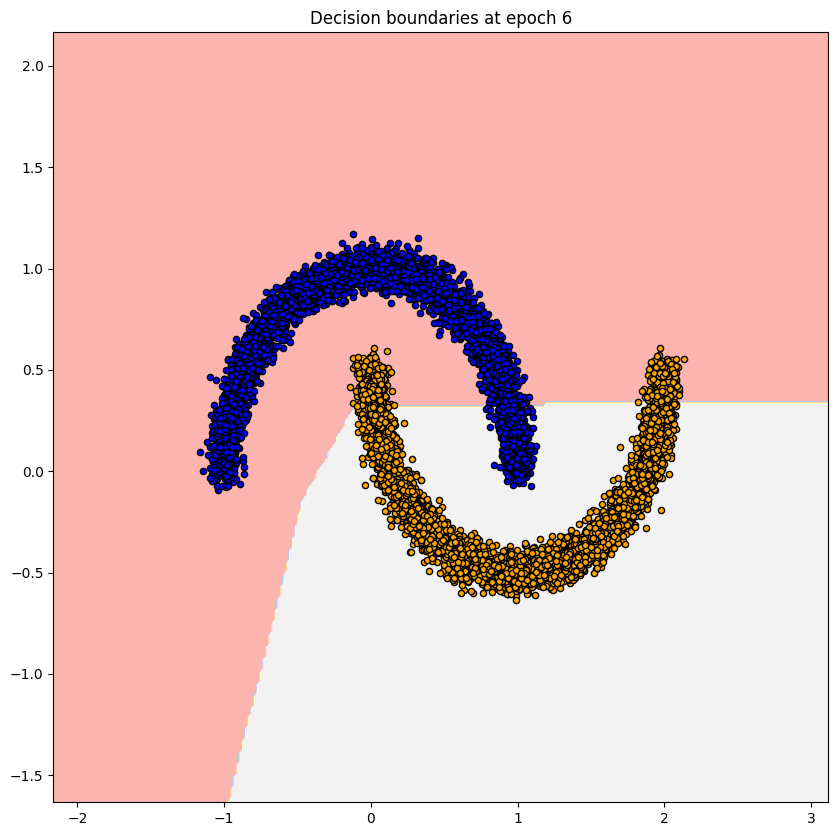

160/160 [==============================] - 4s 24ms/step - loss: 0.2022 - accuracy: 0.8953 - val_loss: 0.2022 - val_accuracy: 0.8950
Epoch 8/11
1582/1582 [==============================] - 2s 1ms/step


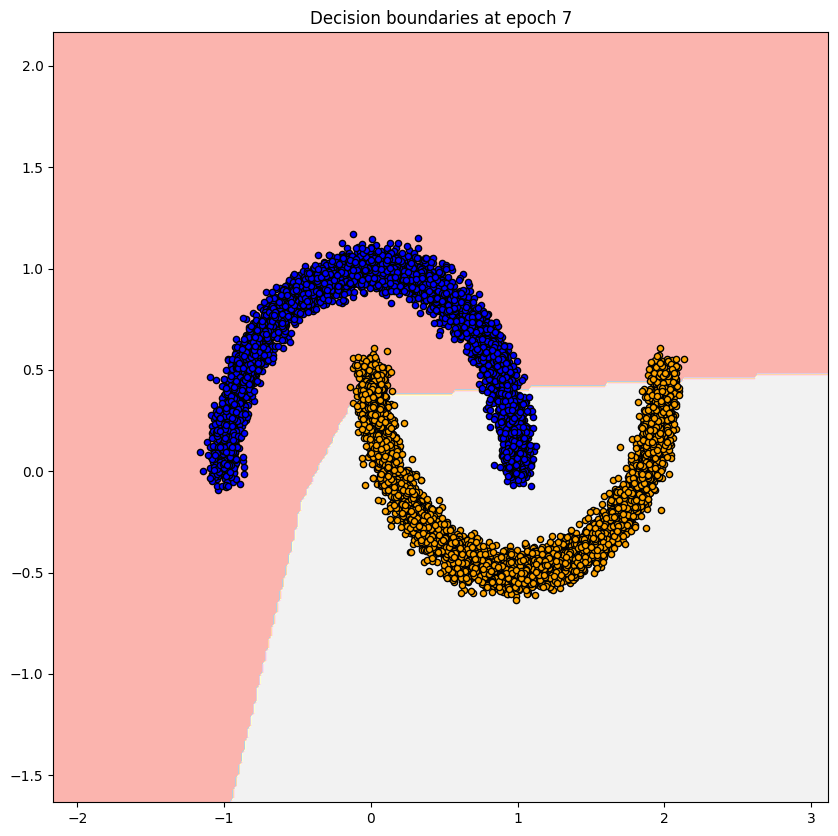

160/160 [==============================] - 4s 24ms/step - loss: 0.2023 - accuracy: 0.8960 - val_loss: 0.2035 - val_accuracy: 0.9040
Epoch 9/11
1582/1582 [==============================] - 2s 1ms/step


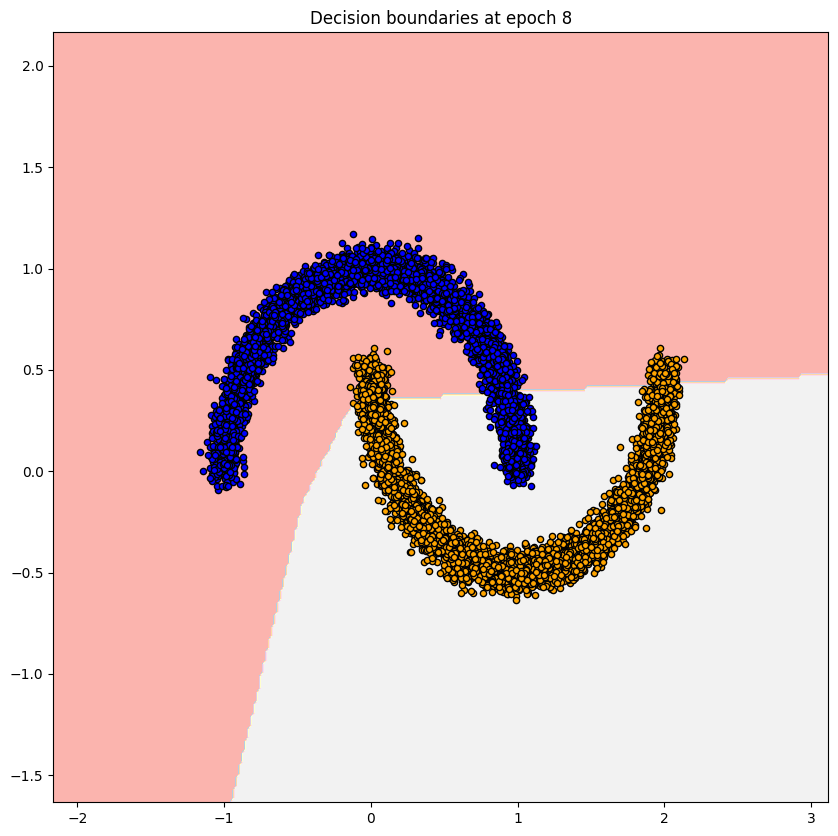

160/160 [==============================] - 4s 23ms/step - loss: 0.2017 - accuracy: 0.8978 - val_loss: 0.2019 - val_accuracy: 0.9040
Epoch 10/11
1582/1582 [==============================] - 2s 1ms/step


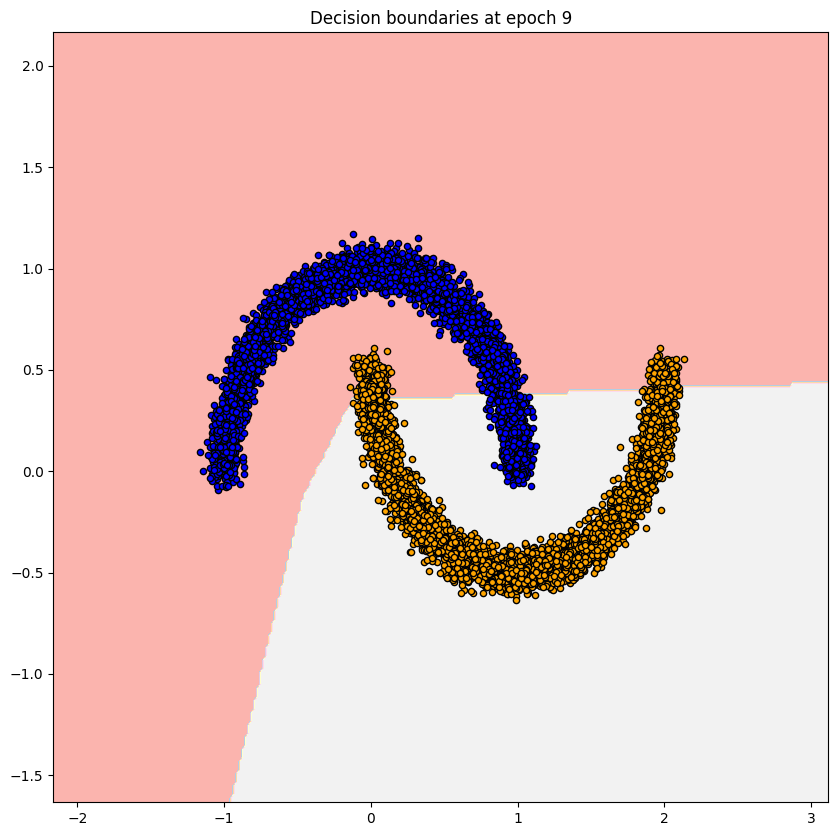

160/160 [==============================] - 4s 24ms/step - loss: 0.2026 - accuracy: 0.8960 - val_loss: 0.2013 - val_accuracy: 0.9050
Epoch 11/11
1582/1582 [==============================] - 2s 1ms/step


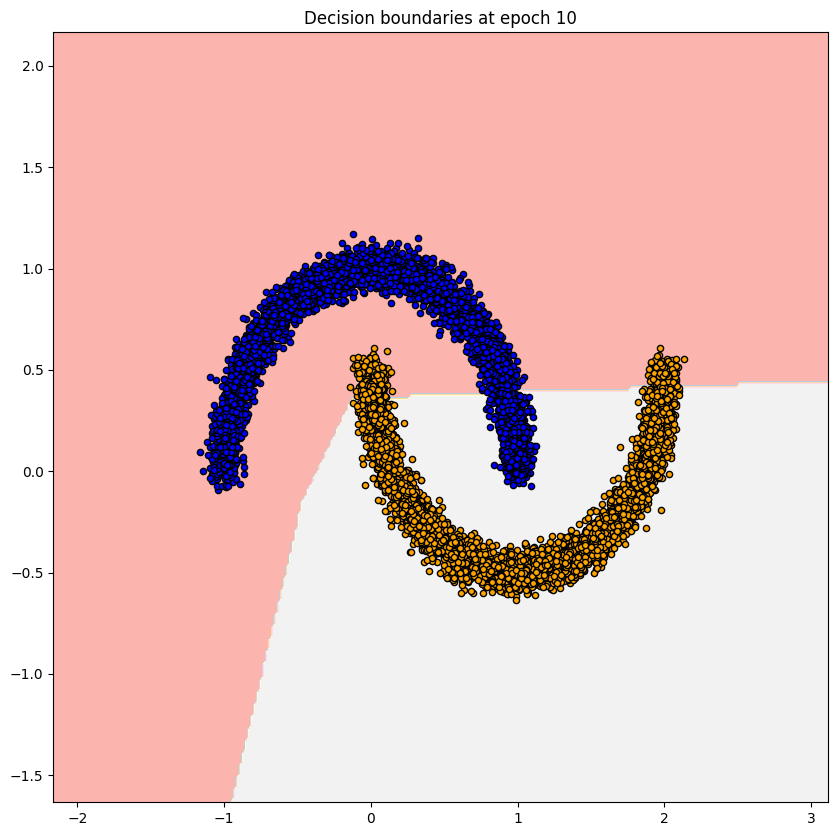

160/160 [==============================] - 4s 23ms/step - loss: 0.2019 - accuracy: 0.8960 - val_loss: 0.2018 - val_accuracy: 0.9065


In [22]:
# Version 1 with ReLU: this is not really comparable with our own implementation which uses Sigmoid, but it works.
tf_model = DeepModel(n_units=[10], activation_functions=["relu"])
# Version 2 with sigmoid: this version does now work (please try uncommenting the line below). There is something 
# interesting here. When we use sigmoid instead of ReLU in the line above, this Keras implementation does not work on
# this problem. Tuning of some parameters would be required to make it work using sigmoid. You may want to try that.
# tf_model = DeepModel(n_units=[10], activation_functions=["sigmoid"])
print("Training Tensorflow model")
callbacks = [BoundariesCallback(X, y, tf_model, plot_freq=1)]
res = tf_model.fit(X, y, callbacks=callbacks, epochs=11)